# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Подключение библиотек

In [2]:
# !pip install geopy ipyleaflet ipywidgets

In [3]:
import pandas as pd
import seaborn as sns

import functools
import operator
import math

# Для географии
from geopy.geocoders import Nominatim
from geopy.distance import geodesic as GD
from ipywidgets import HTML
from ipyleaflet import Map, Marker, Popup

## Получение данных

In [4]:
df = pd.read_csv('/data/apartment_sales_ads.csv', sep='\t')

## Описание данных

- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

Исправляем названия колонок.

In [5]:
df = df.rename({
    'cityCenters_nearest': 'city_centers_nearest',
    'parks_around3000': 'parks_around_3000',
    'ponds_around3000': 'ponds_around_3000'
}, axis=1);

Изменяем порядок колонок для удобства анализа.

In [6]:
df = df[['locality_name', 'last_price', 'first_day_exposition', 'days_exposition',
    'rooms', 'total_area', 'living_area', 'kitchen_area',
    'ceiling_height', 'floors_total', 'floor',       
    'airports_nearest', 'city_centers_nearest',
    'parks_around_3000', 'parks_nearest', 'ponds_around_3000', 'ponds_nearest', 
    'balcony', 'total_images', 'open_plan', 'studio', 'is_apartment']]

## Изучение данных

Проверяем кол-во значений и тип в каждой колонке

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   locality_name         23650 non-null  object 
 1   last_price            23699 non-null  float64
 2   first_day_exposition  23699 non-null  object 
 3   days_exposition       20518 non-null  float64
 4   rooms                 23699 non-null  int64  
 5   total_area            23699 non-null  float64
 6   living_area           21796 non-null  float64
 7   kitchen_area          21421 non-null  float64
 8   ceiling_height        14504 non-null  float64
 9   floors_total          23613 non-null  float64
 10  floor                 23699 non-null  int64  
 11  airports_nearest      18157 non-null  float64
 12  city_centers_nearest  18180 non-null  float64
 13  parks_around_3000     18181 non-null  float64
 14  parks_nearest         8079 non-null   float64
 15  ponds_around_3000  

In [8]:
# При выводе показывать все колонки
pd.options.display.max_columns = None

df

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment
0,Санкт-Петербург,13000000.0,2019-03-07T00:00:00,NaN,3,108.00,51.0,25.00,2.70,16.0,8,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,20,False,False,NaN
1,посёлок Шушары,3350000.0,2018-12-04T00:00:00,81.0,1,40.40,18.6,11.00,NaN,11.0,1,12817.0,18603.0,0.0,NaN,0.0,NaN,2.0,7,False,False,NaN
2,Санкт-Петербург,5196000.0,2015-08-20T00:00:00,558.0,2,56.00,34.3,8.30,NaN,5.0,4,21741.0,13933.0,1.0,90.0,2.0,574.0,0.0,10,False,False,NaN
3,Санкт-Петербург,64900000.0,2015-07-24T00:00:00,424.0,3,159.00,NaN,NaN,NaN,14.0,9,28098.0,6800.0,2.0,84.0,3.0,234.0,0.0,0,False,False,NaN
4,Санкт-Петербург,10000000.0,2018-06-19T00:00:00,121.0,2,100.00,32.0,41.00,3.03,14.0,13,31856.0,8098.0,2.0,112.0,1.0,48.0,NaN,2,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,Санкт-Петербург,9700000.0,2017-03-21T00:00:00,NaN,3,133.81,73.3,13.83,3.70,5.0,3,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN,9,False,False,NaN
23695,Тосно,3100000.0,2018-01-15T00:00:00,45.0,3,59.00,38.0,8.50,NaN,5.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,False,False,NaN
23696,село Рождествено,2500000.0,2018-02-11T00:00:00,NaN,2,56.70,29.7,NaN,NaN,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,False,False,NaN
23697,Санкт-Петербург,11475000.0,2017-03-28T00:00:00,602.0,2,76.75,NaN,23.30,3.00,17.0,12,39140.0,10364.0,2.0,173.0,3.0,196.0,2.0,13,False,False,NaN


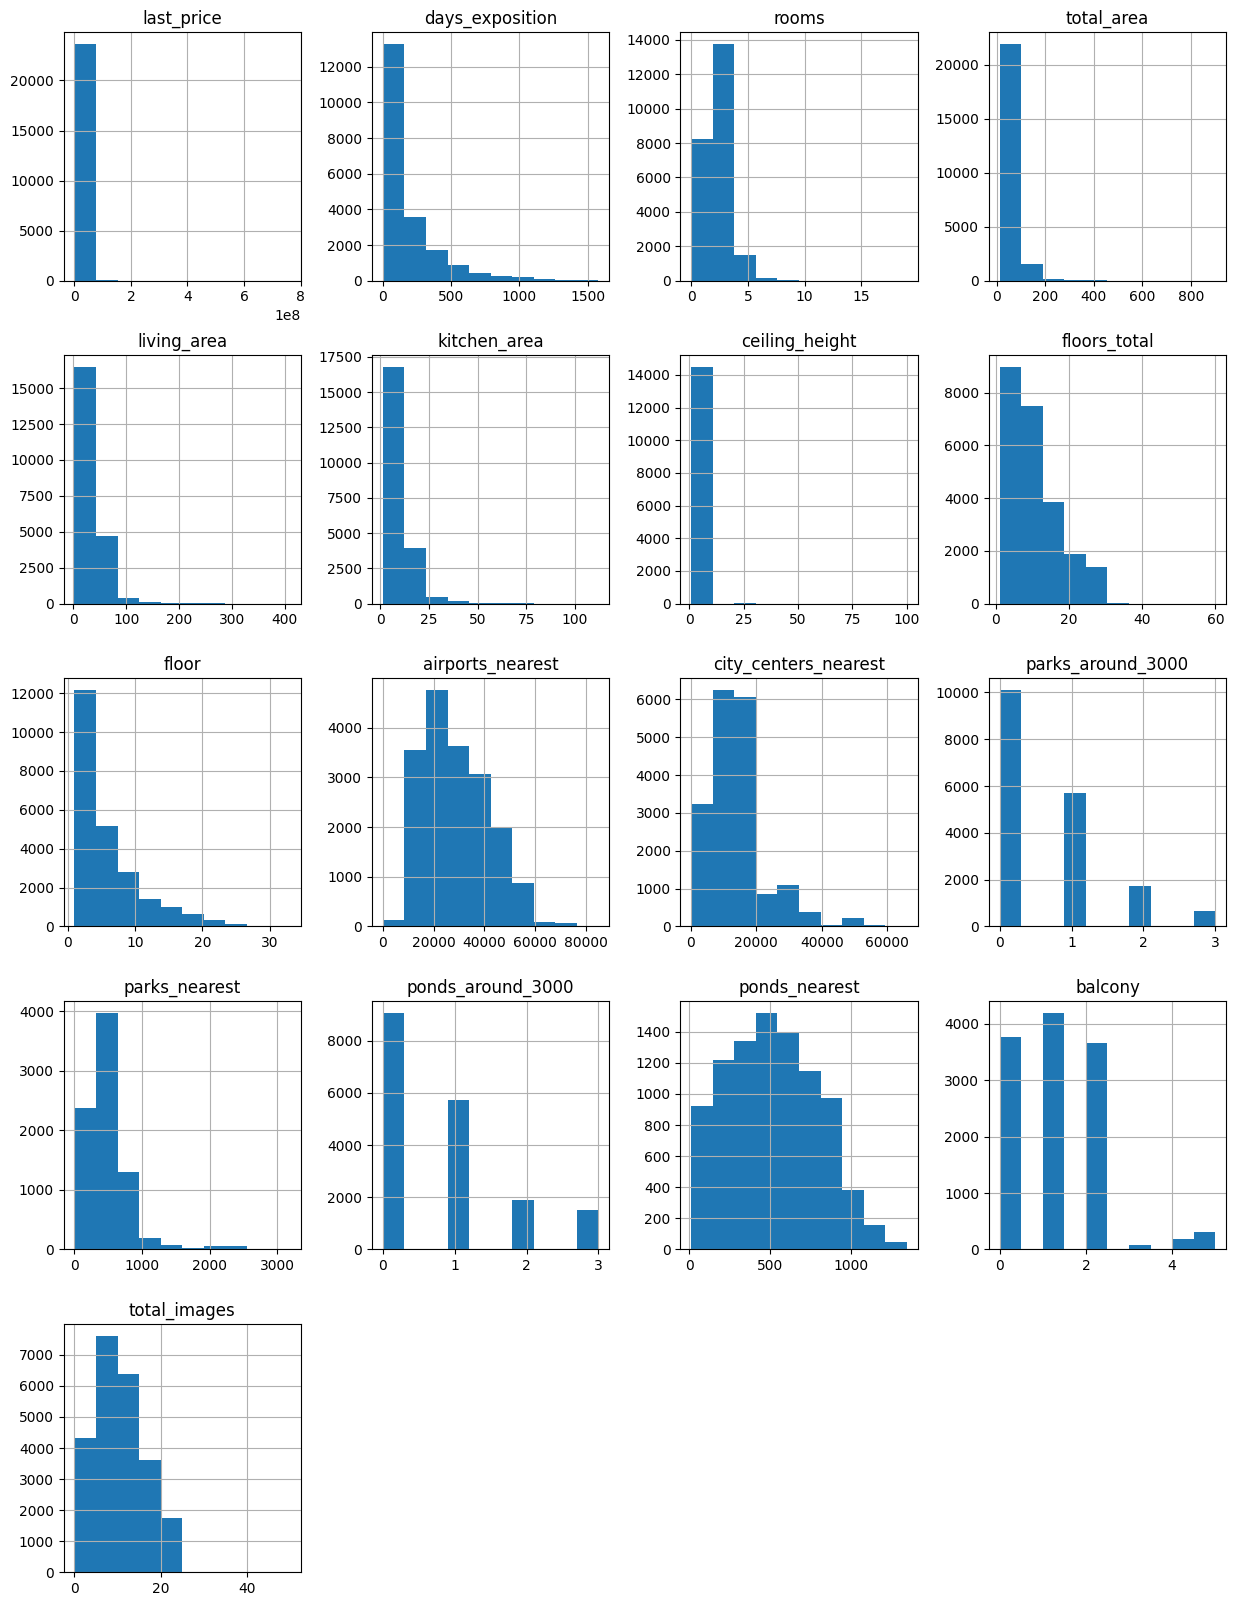

In [9]:
df.hist(figsize=(15, 20));

## Предобработка данных

Проверяем данные по каждому столбцу. Исправляем пропущенные значения, выбросы и дубликаты.

### Населённый пункт

In [10]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [11]:
len(df[df['locality_name'].isna()])

49

Есть 49 `NaN`. Можно было бы предсказать населённый пункт по другим параметрам и заполнить пробелы. Или выделить в отдельную категорию. Но так как "объявления были отобраны для Санкт-Петербурга и соседних населённых пунктов", непонятно как эти записии вообще попали в данные. Удалим их.

In [12]:
df = df.dropna(subset=['locality_name'])

Приведём все используемые слова к нормированному виду

In [13]:
loc_names = list(df['locality_name'].unique())

In [14]:
# Заменяем ё на е
def fix_e(x):
    return x.replace('ё', 'е')

# Для каждой строчки делим на отдельные слова, приводим к строчным буквам, применяем fix_e
def normalize(x):
    return list(map(fix_e, str(x).lower().split(' ')))

# Получаем все уникальные слова которые используются уплощая список
a = set(functools.reduce(operator.iconcat, list(map(normalize,  loc_names)) , []))
a

{'69-й',
 'агалатово',
 'александровская',
 'алексеевка',
 'аннино',
 'аро',
 'барышево',
 'батово',
 'бегуницы',
 'белогорка',
 'белоостров',
 'бокситогорск',
 'большая',
 'большие',
 'большое',
 'большой',
 'бор',
 'борисова',
 'бугры',
 'будогощь',
 'ваганово',
 'важины',
 'вартемяги',
 'вахнова',
 'верево',
 'вещево',
 'виллози',
 'вознесенье',
 'возрождение',
 'войсковицы',
 'войскорово',
 'володарское',
 'волосово',
 'волхов',
 'вруда',
 'всеволожск',
 'выборг',
 'вырица',
 'выскатка',
 'высокоключевой',
 'высоцк',
 'гаврилово',
 'гарболово',
 'гатчина',
 'гладкое',
 'глажево',
 'глебычево',
 'глинка',
 'гончарово',
 'горбунки',
 'горка',
 'городского',
 'городской',
 'гостилицы',
 'грива',
 'громово',
 'девяткино',
 'деревня',
 'дзержинского',
 'долина',
 'дружная',
 'дружноселье',
 'дубровка',
 'елизаветино',
 'ефимовский',
 'железнодорожной',
 'жилгородок',
 'жилпоселок',
 'житково',
 'заводской',
 'заклинье',
 'заневка',
 'запорожское',
 'зеленогорск',
 'зеленый',
 'зимитицы'

Из них можно получить второстепенные слова, которые можно исключить при сравнении

In [15]:
# Удаляем из строки второстепенные слова
def remove_secondary_words(value):
    ns_types = [
        'деревня', 'поселок', 'городского', 'городской', 'типа', 'имени',
        'железнодорожной', 'при', 'село', 'станции', 'коттеджный',
        'садовое', 'садоводческое', 'некоммерческое', 'товарищество'
    ]
    return ' '.join([x for x in fix_e(value).split(' ') if x not in ns_types])

Создаём новый столбец `locality_name_new` без этих слов. Таким образом мы избавились от неявных дубликатов.

In [16]:
df['locality_name_new'] = df['locality_name'].apply(remove_secondary_words)
df['locality_name_new']

C:\Users\user\AppData\Local\Temp\ipykernel_20764\408421409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['locality_name_new'] = df['locality_name'].apply(remove_secondary_words)


0        Санкт-Петербург
1                 Шушары
2        Санкт-Петербург
3        Санкт-Петербург
4        Санкт-Петербург
              ...       
23694    Санкт-Петербург
23695              Тосно
23696        Рождествено
23697    Санкт-Петербург
23698        Новый Учхоз
Name: locality_name_new, Length: 23650, dtype: object

### Число фотографий квартиры

In [17]:
df['total_images'].unique()

array([20,  7, 10,  0,  2,  6,  5, 18,  9,  1, 16, 11,  8, 12, 13,  3, 15,
       17, 14, 19, 32,  4, 35, 39, 23, 21, 27, 30, 24, 25, 28, 31, 22, 29,
       26, 50, 42, 37], dtype=int64)

### Цена на момент снятия с публикации

In [18]:
df['last_price'].unique()

array([13000000.,  3350000.,  5196000., ...,  6151120., 21400000.,
       11475000.])

Пропусков нет. Нет дробной части. Изменяем тип данных с дробного на целое.

In [19]:
df['last_price'] = df['last_price'].astype(int)

C:\Users\user\AppData\Local\Temp\ipykernel_20764\2507314863.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_price'] = df['last_price'].astype(int)


In [20]:
df['last_price'].describe()

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

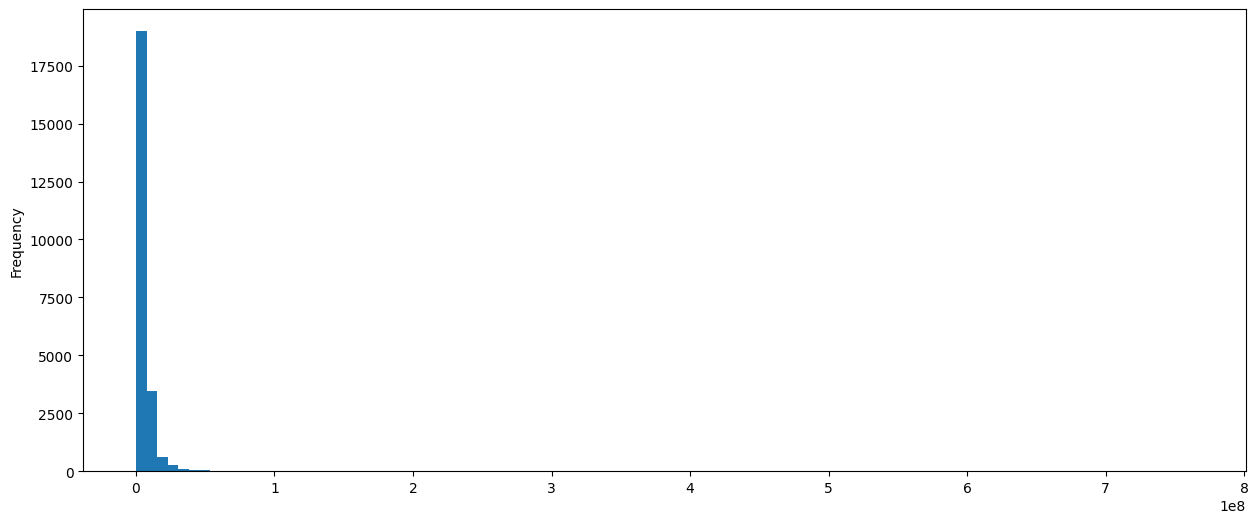

In [21]:
df['last_price'].plot.hist(bins=100, figsize=(15, 6));

**Есть необычно маленькие значения.** Проверим их.

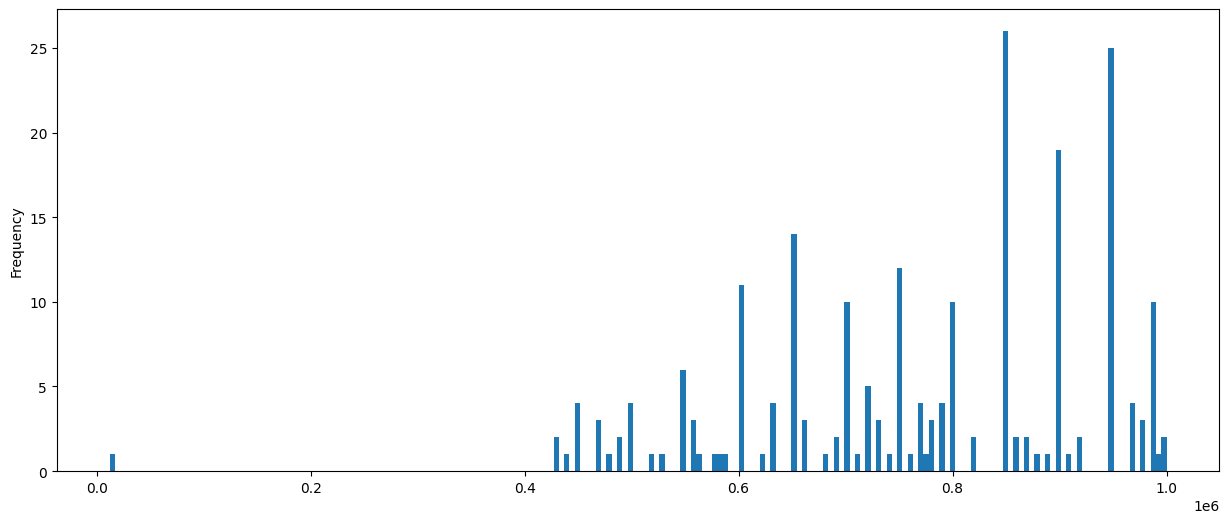

In [22]:
df.loc[df['last_price'] < 1_000_000,'last_price'].plot.hist(bins=200, figsize=(15, 6));

In [23]:
df.query('last_price < 500_000')

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment,locality_name_new
5698,городской посёлок Будогощь,450000,2017-07-31T00:00:00,233.0,2,42.0,23.0,5.8,NaN,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,False,False,NaN,Будогощь
6859,деревня Старополье,490000,2017-12-11T00:00:00,43.0,1,40.0,NaN,NaN,NaN,5.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,False,False,NaN,Старополье
8793,Санкт-Петербург,12190,2019-03-20T00:00:00,8.0,2,109.0,32.0,40.5,2.75,25.0,25,36421.0,9176.0,1.0,805.0,0.0,NaN,NaN,7,False,False,NaN,Санкт-Петербург
9581,деревня Старополье,450000,2018-08-31T00:00:00,96.0,2,43.4,30.3,5.5,NaN,5.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,False,False,NaN,Старополье
10782,Сланцы,490000,2016-05-05T00:00:00,719.0,1,29.1,17.0,5.5,2.50,5.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,False,False,NaN,Сланцы
14911,посёлок станции Свирь,430000,2018-06-26T00:00:00,44.0,2,54.0,NaN,NaN,NaN,3.0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,False,False,NaN,Свирь
16032,Сланцы,480000,2019-01-06T00:00:00,83.0,1,32.0,16.0,NaN,NaN,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,False,False,NaN,Сланцы
16219,деревня Вахнова Кара,450000,2018-07-11T00:00:00,45.0,2,38.5,NaN,NaN,2.65,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,False,False,NaN,Вахнова Кара
16274,деревня Старополье,440000,2018-07-10T00:00:00,45.0,1,40.0,NaN,NaN,NaN,5.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,False,False,NaN,Старополье
17456,Сланцы,430000,2019-04-22T00:00:00,NaN,1,30.4,16.0,6.0,NaN,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,False,False,NaN,Сланцы


Похоже цены корректны так как расположены в маленьких населённых пунктах и похожи друг на друга. Один объект в Санкт-Петербурге с ценой 12190 с индексом 8793 выбивается. Попробуем его восстановить, посмотрим сколько в среднем стоят другие объекты, например с такой же общей площадю в Санкт-Петербурге.

In [24]:
df.query('100 < total_area < 120 and locality_name == "Санкт-Петербург"')['last_price'].mean()

14333068.671755726

Цена 12 190 может быть 12 190 000, пропустили 3 нуля, исправим.

In [25]:
df.loc[8793, 'last_price'] = 12_190_000

**Есть очень большие значения.**

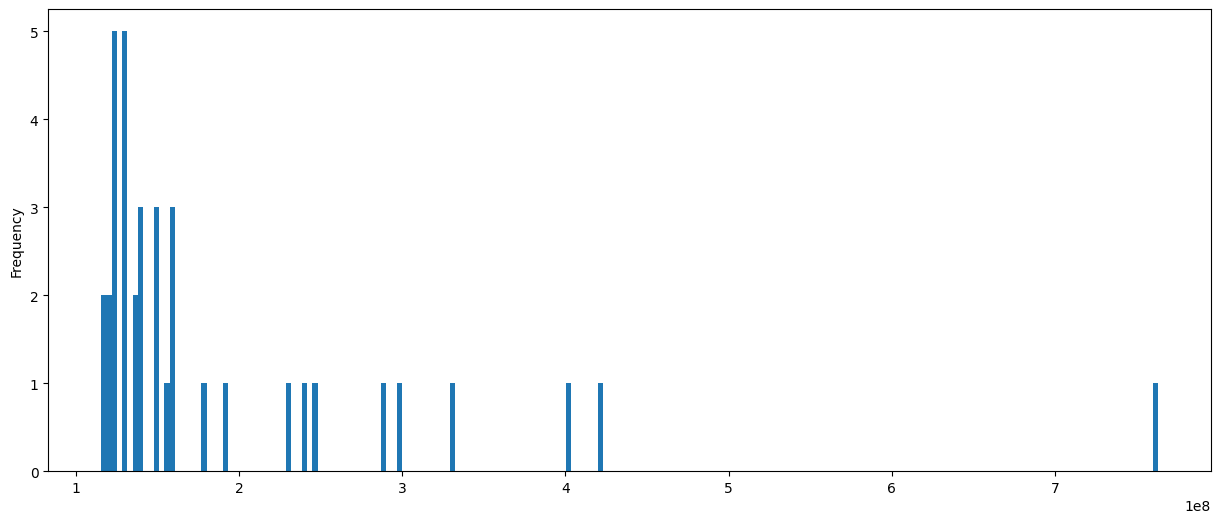

In [26]:
df.loc[df['last_price'] > 100_000_000,'last_price'].plot.hist(bins=200, figsize=(15, 6));

In [27]:
df.query('last_price > 100_000_000')

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment,locality_name_new
793,Санкт-Петербург,135000000,2018-05-22T00:00:00,342.0,4,310.0,250.00,50.00,3.30,5.0,2,34159.0,7251.0,2.0,295.0,3.0,190.0,NaN,20,False,False,NaN,Санкт-Петербург
1026,Санкт-Петербург,155000000,2018-10-12T00:00:00,NaN,5,310.0,190.00,63.00,5.30,3.0,3,24899.0,4785.0,0.0,NaN,1.0,603.0,2.0,20,False,False,NaN,Санкт-Петербург
1188,Санкт-Петербург,118000000,2018-06-01T00:00:00,316.0,6,290.6,188.70,22.00,3.82,6.0,3,25309.0,6224.0,1.0,217.0,0.0,NaN,1.0,20,False,False,NaN,Санкт-Петербург
1300,Санкт-Петербург,120000000,2018-07-12T00:00:00,225.0,5,280.0,162.00,30.00,4.70,4.0,3,24680.0,4247.0,1.0,464.0,3.0,339.0,NaN,14,False,False,NaN,Санкт-Петербург
1436,Санкт-Петербург,330000000,2018-04-04T00:00:00,233.0,3,190.0,95.00,40.00,3.50,7.0,5,23011.0,1197.0,3.0,519.0,3.0,285.0,NaN,19,False,False,NaN,Санкт-Петербург
1928,Санкт-Петербург,125000000,2017-01-24T00:00:00,174.0,4,224.5,163.50,30.00,NaN,4.0,3,22805.0,2335.0,0.0,NaN,2.0,497.0,1.0,11,False,False,False,Санкт-Петербург
2243,Санкт-Петербург,130278280,2015-07-24T00:00:00,599.0,5,304.0,NaN,NaN,3.11,9.0,7,25593.0,5913.0,2.0,164.0,0.0,NaN,0.0,9,False,False,NaN,Санкт-Петербург
2536,Санкт-Петербург,159984000,2015-08-27T00:00:00,501.0,4,242.4,131.00,20.00,3.85,9.0,7,21946.0,2242.0,1.0,679.0,1.0,227.0,0.0,16,False,False,NaN,Санкт-Петербург
3117,Санкт-Петербург,140000000,2019-03-30T00:00:00,NaN,7,631.0,NaN,60.00,NaN,5.0,5,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN,19,False,False,NaN,Санкт-Петербург
4996,Санкт-Петербург,124000000,2017-10-12T00:00:00,45.0,4,124.5,67.20,20.00,3.00,4.0,2,20399.0,1722.0,3.0,302.0,3.0,172.0,NaN,20,False,False,False,Санкт-Петербург


Большие значения выглядят корректными.

### Общая площадь квартиры

In [28]:
df['total_area'].unique()

array([108.  ,  40.4 ,  56.  , ...,  66.86, 133.81,  76.75])

Проверяем может ли сумма кухни и жилого пространства быть больше общей площади

In [29]:
wrong_calc = df.query('kitchen_area + living_area > total_area')
wrong_calc

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment,locality_name_new
184,Санкт-Петербург,2600000,2018-02-14T00:00:00,12.0,1,30.20,26.10,6.20,2.65,9.0,5,13952.0,15031.0,0.0,NaN,1.0,824.0,NaN,7,False,False,NaN,Санкт-Петербург
545,Санкт-Петербург,4700000,2018-12-28T00:00:00,108.0,1,23.80,20.00,5.00,NaN,18.0,9,9731.0,11849.0,0.0,NaN,0.0,NaN,NaN,9,False,False,NaN,Санкт-Петербург
551,посёлок Мурино,3100000,2018-03-08T00:00:00,70.0,1,31.59,30.55,9.28,2.70,19.0,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,8,False,False,NaN,Мурино
601,Санкт-Петербург,5600000,2017-04-18T00:00:00,167.0,2,53.70,48.30,7.00,2.50,12.0,5,50477.0,13252.0,2.0,220.0,1.0,1250.0,2.0,12,False,False,NaN,Санкт-Петербург
696,Санкт-Петербург,3364930,2014-11-27T00:00:00,574.0,1,34.69,23.43,23.43,2.64,25.0,25,43396.0,12153.0,0.0,NaN,0.0,NaN,2.0,1,False,False,NaN,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21824,городской поселок Большая Ижора,2450000,2019-02-12T00:00:00,NaN,2,44.00,38.00,8.60,27.00,2.0,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,20,False,False,False,Большая Ижора
21868,Сосновый Бор,2600000,2018-09-26T00:00:00,107.0,1,34.30,30.60,8.00,2.50,9.0,6,NaN,NaN,NaN,NaN,NaN,NaN,2.0,12,False,False,NaN,Сосновый Бор
21915,Санкт-Петербург,11990000,2016-05-16T00:00:00,93.0,2,91.40,62.00,32.40,NaN,16.0,12,10934.0,12551.0,0.0,NaN,0.0,NaN,0.0,14,False,False,NaN,Санкт-Петербург
21956,Санкт-Петербург,5200000,2018-07-20T00:00:00,7.0,2,46.00,44.00,8.00,NaN,5.0,5,14103.0,15182.0,1.0,488.0,0.0,NaN,1.0,0,False,False,NaN,Санкт-Петербург


Может. Исправляем посчитав сумму жилой площади и кухни.

In [30]:
df.loc[df['kitchen_area'] + df['living_area'] > df['total_area'], 'total_area'] = wrong_calc['kitchen_area'] + wrong_calc['living_area']

### Количество комнат

In [31]:
df['rooms'].unique()

array([ 3,  1,  2,  4,  5,  6,  0,  7, 11,  8, 14, 10, 15,  9, 19, 16, 12],
      dtype=int64)

Странно что есть 0 комнат. Проверим есть ли площади кухни или жилые у объектов у которых 0 комнат.

In [32]:
with pd.option_context("display.max_rows", 1000):
    display(df.query('rooms == 0'))

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment,locality_name_new
144,посёлок Мурино,2450000,2017-03-30T00:00:00,181.0,0,27.00,15.50,NaN,NaN,24.0,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1,False,True,NaN,Мурино
349,деревня Кудрово,2320000,2017-09-27T00:00:00,45.0,0,25.00,17.00,NaN,NaN,14.0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4,True,False,NaN,Кудрово
440,Санкт-Петербург,2480000,2018-03-12T00:00:00,64.0,0,27.11,24.75,NaN,NaN,17.0,4,38171.0,15015.0,0.0,NaN,2.0,982.0,2.0,8,False,True,NaN,Санкт-Петербург
508,посёлок Парголово,3375000,2017-03-28T00:00:00,430.0,0,34.40,24.30,NaN,NaN,26.0,19,53115.0,19292.0,0.0,NaN,1.0,593.0,1.0,0,True,False,NaN,Парголово
608,посёлок Шушары,1850000,2019-02-20T00:00:00,29.0,0,25.00,NaN,NaN,NaN,10.0,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,False,True,NaN,Шушары
697,деревня Кудрово,2500000,2017-12-01T00:00:00,201.0,0,24.10,17.50,NaN,2.75,25.0,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,False,True,NaN,Кудрово
716,посёлок Шушары,1500000,2017-06-07T00:00:00,40.0,0,17.00,12.00,NaN,2.70,9.0,1,18654.0,29846.0,0.0,NaN,0.0,NaN,0.0,5,False,True,NaN,Шушары
780,посёлок Мурино,2600000,2018-02-20T00:00:00,45.0,0,26.10,NaN,NaN,NaN,18.0,8,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9,True,False,NaN,Мурино
839,поселок Новый Свет,1900000,2017-04-14T00:00:00,7.0,0,35.00,15.00,NaN,2.70,5.0,3,NaN,NaN,NaN,NaN,NaN,NaN,1.0,14,True,False,False,Новый Свет
946,посёлок Мурино,2200000,2016-09-27T00:00:00,483.0,0,23.00,18.00,NaN,NaN,27.0,7,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5,True,False,NaN,Мурино


У всех строк есть `total_area` и нет `kitchen_area`, значит как минимум указываем 1 комнату.

In [33]:
df.loc[df['rooms'] == 0, 'rooms'] = 1

### Высота потолков

In [34]:
df['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

Значения выглядят странно. Есть NaN.

Посмотрим на графике и по количеству.

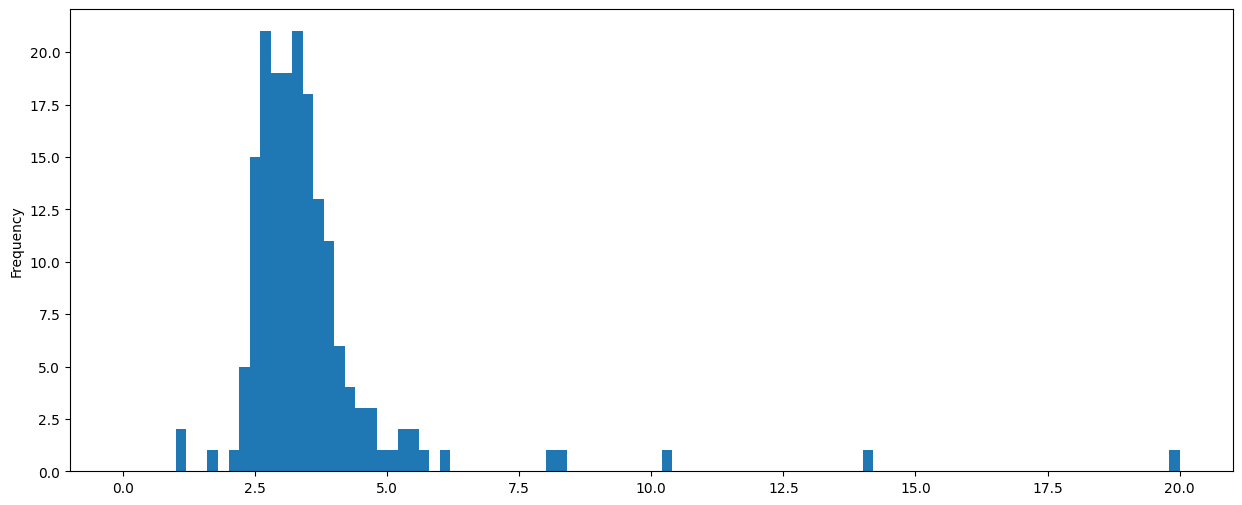

In [35]:
pd.Series(df['ceiling_height'].unique()).plot.hist(bins=100, range=(0, 20), figsize=(15, 6));

In [36]:
with pd.option_context("display.max_rows", 1000):
    display(df['ceiling_height'].value_counts().to_frame())

,ceiling_height
2.50,3515
2.60,1645
2.70,1572
3.00,1109
2.80,993
2.55,980
2.75,906
2.65,676
3.20,276
3.10,203


Похоже что нестандартные высоты начинаются с 8 метров и более

In [37]:
df.query('ceiling_height >= 8')

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment,locality_name_new
355,Гатчина,3600000,2018-07-12T00:00:00,259.0,2,55.2,32.0,NaN,25.0,5.0,2,NaN,NaN,NaN,NaN,NaN,NaN,2.0,17,False,False,False,Гатчина
3148,Волхов,2900000,2018-11-12T00:00:00,NaN,3,75.0,53.0,8.0,32.0,3.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,False,False,NaN,Волхов
3474,деревня Нурма,1400000,2018-03-16T00:00:00,125.0,1,30.0,15.3,7.3,8.0,5.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,False,False,False,Нурма
4643,Санкт-Петербург,4300000,2018-02-01T00:00:00,181.0,2,45.0,30.0,7.0,25.0,9.0,2,12016.0,13256.0,1.0,658.0,1.0,331.0,1.0,0,False,False,NaN,Санкт-Петербург
4876,посёлок Мурино,3000000,2017-09-27T00:00:00,28.0,1,25.0,17.0,NaN,27.0,25.0,17,NaN,NaN,NaN,NaN,NaN,NaN,2.0,7,True,False,NaN,Мурино
5076,Санкт-Петербург,3850000,2018-10-03T00:00:00,7.0,1,30.5,19.5,5.5,24.0,5.0,1,29686.0,8389.0,3.0,397.0,1.0,578.0,NaN,0,False,False,True,Санкт-Петербург
5246,деревня Мины,2500000,2017-10-13T00:00:00,540.0,2,54.0,30.0,9.0,27.0,5.0,3,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0,False,False,NaN,Мины
5669,Санкт-Петербург,4400000,2017-08-08T00:00:00,267.0,2,50.0,21.3,7.0,26.0,9.0,3,28981.0,10912.0,1.0,305.0,0.0,NaN,2.0,4,False,False,NaN,Санкт-Петербург
5807,Санкт-Петербург,8150000,2019-01-09T00:00:00,38.0,2,80.0,41.0,12.0,27.0,36.0,13,18732.0,20444.0,0.0,NaN,3.0,80.0,5.0,17,False,False,NaN,Санкт-Петербург
5863,Санкт-Петербург,5650000,2018-08-15T00:00:00,14.0,1,45.0,19.3,8.3,8.3,16.0,14,13069.0,10763.0,0.0,NaN,1.0,613.0,1.0,20,False,False,NaN,Санкт-Петербург


По 1 значению в 1, 1.2, 1.75 метра выглядит как аномалия. Учитывая что есть двузначные и трёхзначные значения это могло быть значением 10, 12, 17 метров. У двузначных и трёхзначных значений могла быть не правильно поставлена точка. Есть 1 значение 14 метров на 5 этаже в 14 этажном здании, выглядит не правдоподобно, но это и не может быть 1.4 метра. Тоже касается 10.3 метров только 1 значение. 100 метров могло быть 10, но подобных значений мало.

Избавимся от записей с высотой потолка: 1, 1.2, 1.75, 8, 8.3, 10.3, 14, 100

In [38]:
df = df.query('ceiling_height not in [1, 1.2, 1.75, 8, 8.3, 10.3, 14, 100]').reset_index(drop=True)

Остальные значения больше 10 разделим на 10, что бы привести к норме, по тому что больше всего похоже на ошибку ввода и их можно сохранить.

In [39]:
df.loc[df['ceiling_height'] > 10,'ceiling_height'] = df[df['ceiling_height'] > 10]['ceiling_height'] / 10

Так же есть пропущенные значения.

In [40]:
df[df['ceiling_height'].isna()]

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment,locality_name_new
1,посёлок Шушары,3350000,2018-12-04T00:00:00,81.0,1,40.4,18.6,11.0,NaN,11.0,1,12817.0,18603.0,0.0,NaN,0.0,NaN,2.0,7,False,False,NaN,Шушары
2,Санкт-Петербург,5196000,2015-08-20T00:00:00,558.0,2,56.0,34.3,8.3,NaN,5.0,4,21741.0,13933.0,1.0,90.0,2.0,574.0,0.0,10,False,False,NaN,Санкт-Петербург
3,Санкт-Петербург,64900000,2015-07-24T00:00:00,424.0,3,159.0,NaN,NaN,NaN,14.0,9,28098.0,6800.0,2.0,84.0,3.0,234.0,0.0,0,False,False,NaN,Санкт-Петербург
5,городской посёлок Янино-1,2890000,2018-09-10T00:00:00,55.0,1,30.4,14.4,9.1,NaN,12.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,False,False,NaN,Янино-1
6,посёлок Парголово,3700000,2017-11-02T00:00:00,155.0,1,37.3,10.6,14.4,NaN,26.0,6,52996.0,19143.0,0.0,NaN,0.0,NaN,1.0,6,False,False,NaN,Парголово
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23628,Санкт-Петербург,3200000,2017-12-16T00:00:00,38.0,1,39.0,20.0,11.0,NaN,9.0,6,40837.0,16704.0,0.0,NaN,0.0,NaN,2.0,6,False,False,NaN,Санкт-Петербург
23631,Санкт-Петербург,5500000,2018-07-19T00:00:00,15.0,2,52.0,31.0,6.0,NaN,5.0,2,20151.0,6263.0,1.0,300.0,0.0,NaN,NaN,3,False,False,NaN,Санкт-Петербург
23633,Тихвин,1350000,2017-07-07T00:00:00,413.0,1,30.0,17.5,6.0,NaN,5.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,False,False,NaN,Тихвин
23636,Тосно,3100000,2018-01-15T00:00:00,45.0,3,59.0,38.0,8.5,NaN,5.0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14,False,False,NaN,Тосно


In [41]:
df['ceiling_height'].describe()

count    14480.000000
mean         2.726368
std          0.278475
min          2.000000
25%          2.510000
50%          2.650000
75%          2.800000
max          6.000000
Name: ceiling_height, dtype: float64

Отсутствие 9195 значений из 23699 может сильно повлиять на результаты исследования, по этому лучше их сохранить. Так как аномальных значений не осталось, а медана не сильно отличается от среднего, лучше заменить пропущенные значения средним.

In [42]:
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].mean())

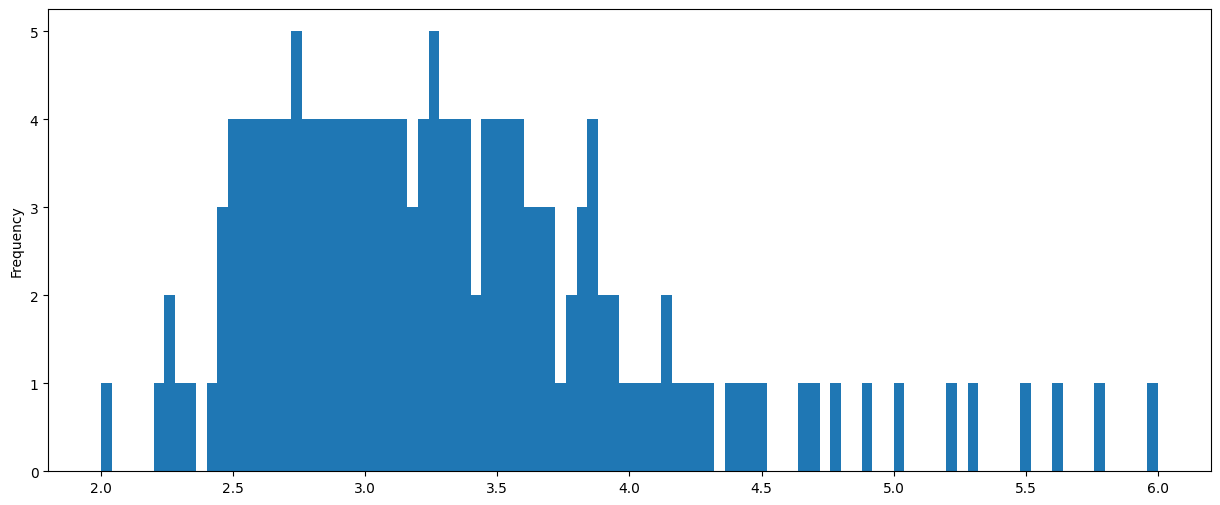

In [43]:
pd.Series(df['ceiling_height'].unique()).plot.hist(bins=100, figsize=(15, 6));

### Всего этажей в доме

In [44]:
df['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52.])

Посмотрим количество пропущенных значений.

In [45]:
len(df[df['floors_total'].isna()])

85

Всего 86 довольно мало. Восстановить не представляется возможным. Удаляем.

In [46]:
df = df.dropna(subset=['floors_total'])

Исправим тип данных на int

In [47]:
df['floors_total'] = df['floors_total'].astype(int)

###  Жилая площадь

In [48]:
df['living_area'].unique()

array([51.  , 18.6 , 34.3 , ..., 31.65, 13.59, 42.55])

Если жилая площадь не указана, возможно её нет. Исправляем на 0.

In [49]:
df[df['living_area'].isna()]

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment,locality_name_new
3,Санкт-Петербург,64900000,2015-07-24T00:00:00,424.0,3,159.00,NaN,NaN,2.726368,14,9,28098.0,6800.0,2.0,84.0,3.0,234.0,0.0,0,False,False,NaN,Санкт-Петербург
7,Санкт-Петербург,7915000,2019-04-18T00:00:00,NaN,2,71.60,NaN,18.9,2.726368,24,22,23982.0,11634.0,0.0,NaN,0.0,NaN,2.0,5,False,False,NaN,Санкт-Петербург
30,Коммунар,2200000,2018-02-19T00:00:00,63.0,1,32.80,NaN,NaN,2.726368,9,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,False,False,NaN,Коммунар
37,поселок городского типа Красный Бор,1990000,2017-10-28T00:00:00,196.0,2,45.80,NaN,NaN,2.500000,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,False,False,NaN,Красный Бор
44,Санкт-Петербург,5350000,2018-11-18T00:00:00,NaN,1,40.00,NaN,NaN,2.726368,22,3,30471.0,11603.0,1.0,620.0,1.0,1152.0,1.0,13,False,False,NaN,Санкт-Петербург
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23583,Колпино,5950000,2018-07-03T00:00:00,60.0,3,80.30,NaN,NaN,2.700000,12,5,27933.0,33719.0,0.0,NaN,2.0,562.0,NaN,14,False,False,NaN,Колпино
23604,Санкт-Петербург,6400000,2018-01-12T00:00:00,59.0,4,88.00,NaN,NaN,2.550000,10,1,33642.0,13943.0,0.0,NaN,2.0,844.0,NaN,12,False,False,NaN,Санкт-Петербург
23611,поселок городского типа Синявино,2450000,2018-02-08T00:00:00,45.0,1,45.60,NaN,NaN,2.800000,9,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,False,False,NaN,Синявино
23620,Сосновый Бор,2500000,2017-12-08T00:00:00,45.0,1,35.00,NaN,NaN,2.726368,9,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,False,NaN,Сосновый Бор


In [50]:
df['living_area'] = df['living_area'].fillna(0)

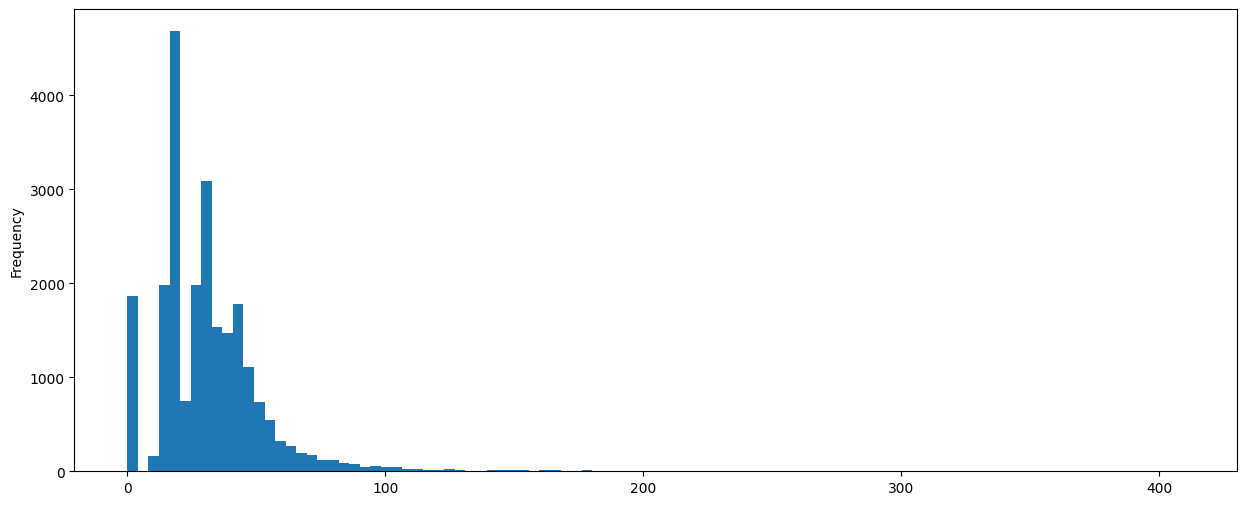

In [51]:
df['living_area'].plot.hist(bins=100, figsize=(15, 6));

### Этаж

In [52]:
df['floor'].unique()

array([ 8,  1,  4,  9, 13,  5,  6, 22, 26,  7,  3,  2, 11, 15, 18, 10, 19,
       16, 20, 27, 25, 17, 14, 12, 21, 28, 24, 23, 30, 29, 32, 33, 31],
      dtype=int64)

Проверим могло быть такое что указанный этаж больше максимального количества этажей.

In [53]:
len(df.query('floor > floors_total'))

0

Таких нет.

### Апартаменты

In [54]:
df['is_apartment'].unique()

array([nan, False, True], dtype=object)

Если значение NaN это может значить что это не апартаменты. Заменим их False.

In [55]:
df['is_apartment'] = df['is_apartment'].fillna(False)

### Студия

In [56]:
df['studio'].unique()

array([False,  True])

### Свободная планировка

In [57]:
df['open_plan'].unique()

array([False,  True])

### Площадь кухни

In [58]:
df['kitchen_area'].unique()

array([ 25.  ,  11.  ,   8.3 ,    nan,  41.  ,   9.1 ,  14.4 ,  18.9 ,
         8.81,   6.5 ,   8.5 ,   6.  ,   9.  ,   5.2 ,   8.  ,   7.6 ,
         5.6 ,  12.  ,   5.7 ,   6.1 ,  19.6 ,  15.  ,   7.  ,   9.2 ,
        11.7 ,  13.4 ,  17.  ,   6.3 ,  11.6 ,   8.8 ,  10.  ,  17.6 ,
         7.5 ,   9.5 ,  50.  ,  15.5 ,  10.7 ,  11.1 ,  20.  ,  11.9 ,
        16.  ,   5.3 ,  11.5 ,   7.2 ,   6.2 ,  10.4 ,   7.1 ,   4.9 ,
         7.3 ,  11.95,  10.2 ,   6.4 ,   5.5 ,  13.  ,   8.4 ,  23.6 ,
        10.8 ,  18.3 ,   5.  ,   8.2 ,  24.  ,  23.8 ,   6.6 ,  26.85,
        15.4 ,   7.8 ,  33.8 ,   5.4 ,  12.72,  12.2 ,  19.  ,  12.4 ,
         7.9 ,  10.3 ,   9.8 ,  17.5 ,  14.7 ,  20.91,  21.3 ,  10.6 ,
        10.9 ,   9.7 ,   7.7 ,  12.5 ,  11.4 ,   8.6 ,  11.24,  14.1 ,
        15.7 ,  13.29,  14.  ,  12.9 ,  12.7 ,  16.5 ,   9.36,  21.5 ,
        35.  ,  10.5 ,   8.7 ,  19.3 ,  21.4 ,  40.  ,  49.2 ,  11.52,
         8.9 ,   9.6 ,  30.  ,  14.2 ,   8.1 ,  10.44,   4.5 ,  16.3 ,
      

In [59]:
df['kitchen_area'] = df['kitchen_area'].fillna(0)

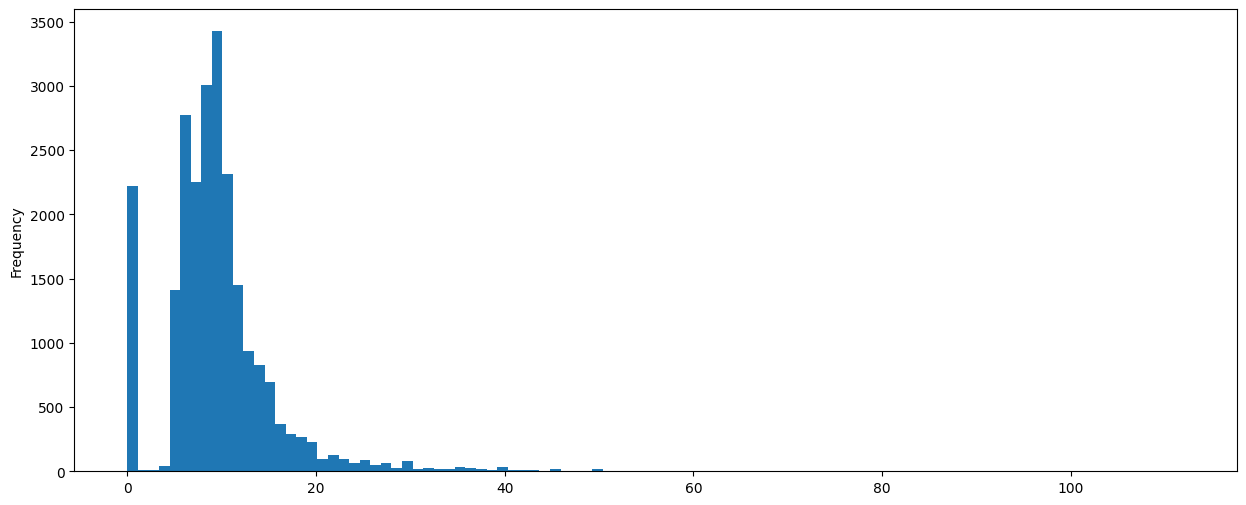

In [60]:
df['kitchen_area'].plot.hist(bins=100, figsize=(15, 6));

### Количество балконов

In [61]:
df['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

Если количество балконов не указано, скорее всего их нет. Указываем 0 и исправляем тип данных на `int`

In [62]:
df['balcony'] = df['balcony'].fillna(0).astype(int)

### Расстояние до аэропорта

In [63]:
df['airports_nearest'].unique()

array([18863., 12817., 21741., ..., 11751., 20151., 24665.])

Проверим пропущенные значения.

In [64]:
len(df[df['airports_nearest'].isna()])

5522

Значений очень много. Сгруппируем по населённым пунктам, по каждому найдём среднее расстояние до аэропорта из имеющихся и заполним этим средним у тех же городов где значения пропущены.

In [65]:
df['airports_nearest'] = df['airports_nearest'].fillna(df.groupby('locality_name_new')['airports_nearest'].transform('median'))

In [66]:
len(df[df['airports_nearest'].isna()])

5430

Пропущенных значений так же много.  
Получим географические координаты населённых пунктов и рассчитаем пропущенные расстояния к ближайшему аэропорту.

In [75]:
len(df[df['airports_nearest'].isna()])

0

In [67]:
x = df.pivot_table(index='locality_name_new', values='airports_nearest', aggfunc='count')
x = x.reset_index()
x.columns = ['locality_name_new', 'count']
x

,locality_name_new,count
0,Агалатово,0
1,Александровская,2
2,Алексеевка,0
3,Аннино,0
4,Аро,0
...,...,...
300,Юкки,0
301,Ялгино,0
302,Яльгелево,0
303,Ям-Тесово,0


In [68]:
# Получаем экземпляр для поиска координат населённых пунктов
geolocator = Nominatim(user_agent="my_request")

In [69]:
# Функция поиска координат,
# ❗ выполняется около 3 минут находит не все значения,
# приходится исправлять вручную
def find_coords():
    for i in range(len(x)):
        try:
            la_lo = geolocator.geocode('Россия, Ленинградская область, ' + x.loc[i, 'locality_name_new'])
            # широта
            x.loc[i, 'latitude'] = la_lo.latitude
            # долгота
            x.loc[i, 'longitude'] = la_lo.longitude
        except:
            x.loc[i, 'latitude'] = x.loc[i, 'locality_name_new']
            x.loc[i, 'longitude'] = x.loc[i, 'locality_name_new']

find_coords()

In [81]:
with pd.option_context('display.max_rows', 1000):
    display(x)

,locality_name_new,count,latitude,longitude
0,Агалатово,0,60.218694,30.293129
1,Александровская,2,59.664109,30.158331
2,Алексеевка,0,59.433152,28.776243
3,Аннино,0,59.771225,30.051805
4,Аро,0,59.926559,30.654613
5,Барышево,0,60.692173,29.591753
6,Батово,0,59.318753,29.900555
7,Бегуницы,0,59.584716,29.304908
8,Белогорка,0,59.348839,30.131502
9,Белоостров,1,60.169039,30.01613


In [82]:
# Здесь ручное исправление
x.loc[64,  'latitude'], x.loc[64,  'longitude'] = 60.197581, 29.707035 # Зеленогорск
x.loc[104, 'latitude'], x.loc[104, 'longitude'] = 59.991790, 29.775846 # Кронштадт
x.loc[116, 'latitude'], x.loc[116, 'longitude'] = 60.103706, 30.206238 # Левашово
x.loc[122, 'latitude'], x.loc[122, 'longitude'] = 60.013964, 30.009201 # Лисий Нос
x.loc[128, 'latitude'], x.loc[128, 'longitude'] = 59.592964, 30.301765 # Лукаши
x.loc[139, 'latitude'], x.loc[139, 'longitude'] = 59.808048, 30.573730 # Металлострой
x.loc[184, 'latitude'], x.loc[184, 'longitude'] = 60.509943, 30.229809 # Платформа 69-й километр
x.loc[190, 'latitude'], x.loc[190, 'longitude'] = 59.784037, 30.627700 # Понтонный
x.loc[237, 'latitude'], x.loc[237, 'longitude'] = 60.093474, 29.972038 # Сестрорецк
x.loc[256, 'latitude'], x.loc[256, 'longitude'] = 59.761178, 30.033258 # Стрельна
x.loc[282, 'latitude'], x.loc[282, 'longitude'] = 59.803518, 30.604685 # Усть-Ижора
x.loc[298, 'latitude'], x.loc[298, 'longitude'] = 59.807224, 30.379523 # Шушары

x['latitude'] = x['latitude'].astype(float)
x['longitude'] = x['longitude'].astype(float)

Расстояние будем считать до аэропорта Пулково

In [83]:
pulkovo_coord = [59.799805, 30.273021]

In [84]:
def calc_distance_pulkovo(raw):
    return GD([raw['latitude'], raw['longitude']], pulkovo_coord).m

In [85]:
x['airports_nearest'] = x.apply(calc_distance_pulkovo, axis=1)

In [86]:
with pd.option_context('display.max_rows', 1000):
    display(x)

,locality_name_new,count,latitude,longitude,airports_nearest
0,Агалатово,0,60.218694,30.293129,46682.890468
1,Александровская,2,59.664109,30.158331,16436.592516
2,Алексеевка,0,59.433152,28.776243,93838.581039
3,Аннино,0,59.771225,30.051805,12825.192037
4,Аро,0,59.926559,30.654613,25623.272438
5,Барышево,0,60.692173,29.591753,106342.078400
6,Батово,0,59.318753,29.900555,57580.597464
7,Бегуницы,0,59.584716,29.304908,59554.300988
8,Белогорка,0,59.348839,30.131502,50872.484608
9,Белоостров,1,60.169039,30.016130,43565.205839


Назначим всем пропускам `airports_nearest` в соответствии с `locality_name_new`

In [ ]:
def match_name_km_airports(raw):
    if pd.isna(raw['airports_nearest']):
        return x.loc[x['locality_name_new'] == raw['locality_name_new'], 'airports_nearest'].values[0]
    else:
        return raw['airports_nearest']

df['airports_nearest'] = df.apply(match_name_km_airports, axis=1)

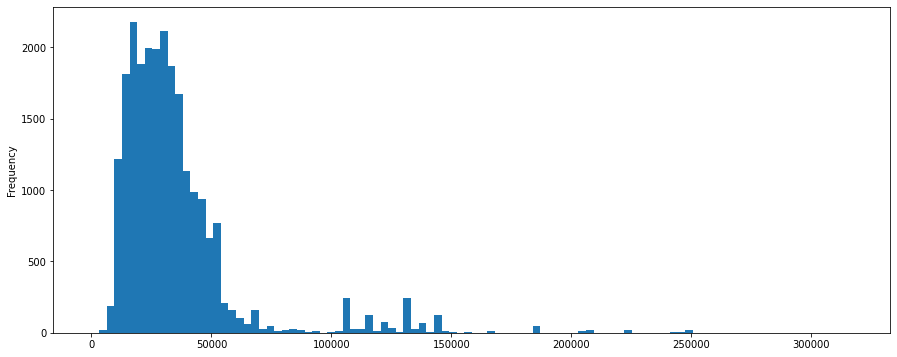

In [ ]:
df['airports_nearest'].plot.hist(bins=100, figsize=(15, 6));

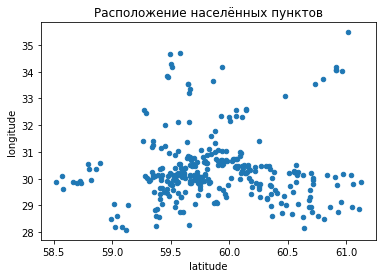

In [ ]:
x.plot.scatter(x='latitude', y='longitude', title='Расположение населённых пунктов');

### Расстояние до центра города

In [ ]:
df['city_centers_nearest'].unique()

array([16028., 18603., 13933., ..., 27977.,  7262.,  6263.])

Проверим пропущенные значения.

In [ ]:
len(df[df['city_centers_nearest'].isna()])

5499

Значений очень много. Сгруппируем по населённым пунктам, по каждому найдём среднее расстояние до центра города из имеющихся и заполним этим средним у тех же городов где значения пропущены.

In [ ]:
df['city_centers_nearest'] = df['city_centers_nearest'].fillna(df.groupby('locality_name_new')['city_centers_nearest'].transform('median'))

In [ ]:
len(df[df['city_centers_nearest'].isna()])

5430

Пропущенных значений так же много.  
Получим географические координаты населённых пунктов и рассчитаем пропущенные расстояния к центру города.  
(я заметил что расстояние до центра города это расстояние до центра Санкт-Петербурга и не напрямую, а по кратчайшему маршруту, здесь я буду добавлять расстояние по прямой, для простоты)

Координаты Санкт-Петербурга

In [ ]:
st_petersbug_coord = [59.939099, 30.315877]

In [ ]:
def calc_distance_st_petersbug(raw):
    return GD([raw['latitude'], raw['longitude']], st_petersbug_coord).m

In [ ]:
x['city_centers_nearest'] = x.apply(calc_distance_st_petersbug, axis=1)

Назначим всем пропускам `city_centers_nearest` в соответствии с `locality_name_new`

In [ ]:
def match_name_km_st_petersbug(raw):
    if pd.isna(raw['city_centers_nearest']):
        return x.loc[x['locality_name_new'] == raw['locality_name_new'], 'city_centers_nearest'].values[0]
    else:
        return raw['city_centers_nearest']

df['city_centers_nearest'] = df.apply(match_name_km_st_petersbug, axis=1)

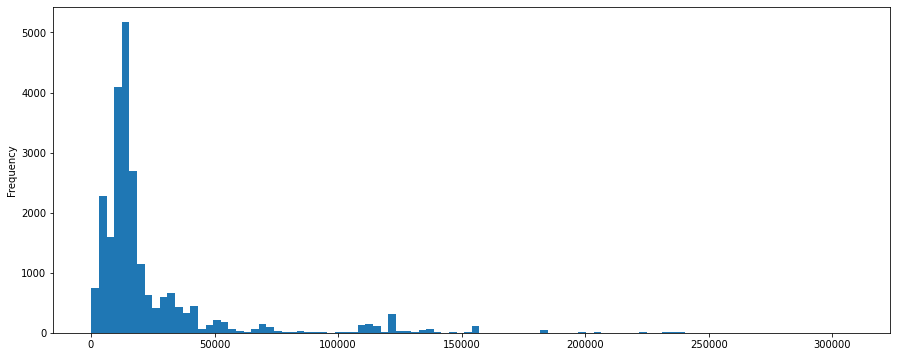

In [ ]:
df['city_centers_nearest'].plot.hist(bins=100, figsize=(15, 6));

### Число парков в районе 3 км

In [ ]:
df['parks_around_3000'].unique()

array([ 1.,  0.,  2., nan,  3.])

Если значение пропущено парков скорее всего нет, запишем 0. Исправим тип на `int`

In [ ]:
df['parks_around_3000'] = df['parks_around_3000'].fillna(0).astype(int)

Если есть расстояние до парка, то должен быть хотя бы 1 парк

In [ ]:
df.loc[(df['parks_around_3000'] == 0) & (~df['parks_nearest'].isna()), 'parks_around_3000'] = 1

### Расстояние до ближайшего парка

In [ ]:
df['parks_nearest'].unique()

array([4.820e+02,       nan, 9.000e+01, 8.400e+01, 1.120e+02, 3.100e+02,
       2.940e+02, 5.900e+02, 4.200e+02, 7.590e+02, 2.480e+02, 5.170e+02,
       4.110e+02, 4.520e+02, 5.320e+02, 4.590e+02, 7.250e+02, 4.700e+01,
       6.200e+02, 6.750e+02, 5.310e+02, 5.260e+02, 2.710e+02, 3.630e+02,
       6.480e+02, 3.820e+02, 3.340e+02, 1.670e+02, 4.450e+02, 2.310e+02,
       5.110e+02, 7.510e+02, 6.660e+02, 3.840e+02, 1.270e+02, 2.410e+02,
       4.880e+02, 1.560e+02, 5.760e+02, 2.850e+02, 6.330e+02, 1.500e+01,
       2.150e+02, 5.330e+02, 1.410e+02, 3.660e+02, 3.410e+02, 5.890e+02,
       3.440e+02, 5.080e+02, 4.170e+02, 7.620e+02, 4.410e+02, 5.590e+02,
       7.490e+02, 5.010e+02, 1.000e+01, 1.133e+03, 1.205e+03, 5.160e+02,
       8.600e+02, 2.760e+02, 9.800e+02, 4.630e+02, 5.910e+02, 2.390e+02,
       6.510e+02, 1.021e+03, 4.850e+02, 5.860e+02, 3.700e+02, 6.880e+02,
       2.750e+02, 5.460e+02, 4.660e+02, 1.390e+02, 2.510e+02, 5.370e+02,
       6.270e+02, 1.040e+02, 4.500e+02, 6.570e+02, 

In [ ]:
df[(df['parks_nearest'].isna()) & (df['parks_around_3000'] > 0)]

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment,locality_name_new


In [ ]:
df.loc[df['parks_nearest'].isna(), 'parks_nearest'] = 0

In [ ]:
df['parks_nearest'] = df['parks_nearest'].fillna(0).astype(int)

### Число водоёмов в радиусе 3 км

In [ ]:
df['ponds_around_3000'].unique()

array([ 2.,  0.,  3.,  1., nan])

Если значение пропущено водоёмов скорее всего нет, запишем 0. Исправим тип на `int`

In [ ]:
df['ponds_around_3000'] = df['ponds_around_3000'].fillna(0).astype(int)

Если есть расстояние до водоёма, то должен быть хотя бы 1 водоём

In [ ]:
df.loc[(df['ponds_around_3000'] == 0) & (~df['ponds_nearest'].isna()), 'ponds_around_3000']

Series([], Name: ponds_around_3000, dtype: int64)

Здесь всё нормально.

### Расстояние до ближайшего водоёма

In [ ]:
df['ponds_nearest'].unique()

array([ 755.,   nan,  574., ...,   40.,   30., 1134.])

Есть ли водоёмы с количеством и без расстояния?

In [ ]:
df[(df['ponds_nearest'] > 0) & (df['ponds_around_3000'].isna())]

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment,locality_name_new


Таких нет.

Отсутствующие значения заполним нулями. Изменим тип на `int`

In [ ]:
df['ponds_nearest'] = df['ponds_nearest'].fillna(0).astype(int)

### Дней с публикации до закрытия объявления

In [ ]:
df['days_exposition'].unique()

array([  nan,   81.,  558., ..., 1360., 1007.,  971.])

Посмотрим количество пропусков

In [ ]:
len(df[df['days_exposition'].isna()])

3171

По каждому городу найдём медианное количество дней за которые там продавались объекты и заполним этими значениями пропущенные.

In [ ]:
df['days_exposition'] = df['days_exposition'].fillna(df.groupby('locality_name_new')['days_exposition'].transform('median'))

Для оставшихся пропусков возьмём медианное значение по всем городам.

In [ ]:
df['days_exposition'] = df['days_exposition'].fillna(df['days_exposition'].median())

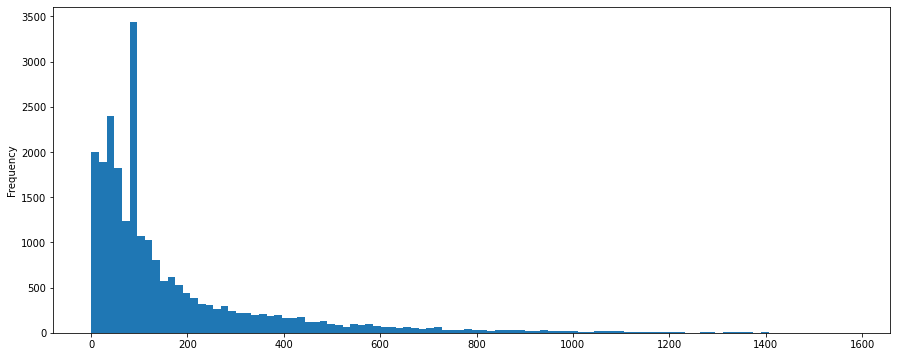

In [ ]:
df['days_exposition'].plot.hist(bins=100, figsize=(15, 6));

### Проверка на явные дубликаты

In [ ]:
# Без колонки 'locality_name'
df[['locality_name_new', 'last_price', 'first_day_exposition', 'days_exposition',
    'rooms', 'total_area', 'living_area', 'kitchen_area',
    'ceiling_height', 'floors_total', 'floor',       
    'airports_nearest', 'city_centers_nearest',
    'parks_around_3000', 'parks_nearest', 'ponds_around_3000', 'ponds_nearest', 
    'balcony', 'total_images', 'open_plan', 'studio', 'is_apartment']].duplicated().sum()

0

### Рекомендации команде предоставляющей данные

Для улучшения качества выгрузки, предотвращения ошибок, сокращения времени работы аналитика.

По возможности:
- Переименовать столбцы `cityCenters_nearest`, `parks_around3000`, `ponds_around3000` на `city_centers_nearest`, `parks_around_3000', `ponds_around_3000` соответственно, для соблюдения единого стиля именования.
- Для `locality_name` необходимо предлагать пользователю варианты из заранее предложенного списка, для избежания дубликатов.
- Для `last_price` изменить тип с `float` на `int`. Скорее всего пользователи совершают ошибки при вводе значений, предупреждать пользователя если цена сильно не соответствует рыночной, для указанного региона.
- Сумма `kitchen_area` и `living_area` не должна быть больше `total_area`, нужно добавить проверку в форме ввода.
- Для `rooms` исключить попадание 0 комнат в данные.
- Для `ceiling_height` ввести проверку значений, предупреждать или запрещать вводить значения которых быть не может, например в диапазоне от 1.8 до 8 метров. Исключить поподание `NaN` в данные.
- Для `floors_total` исключить поподание `NaN` в данные и изменить тип с `float` на `int`.
- Для `is_apartment` исключить поподание `NaN` в данные.
- Для `balcony` исключить поподание `NaN` в данные и изменить тип с `float` на `int`.
- Для `airports_nearest` и `city_centers_nearest` в описании нужно уточнить что это кратчайший маршрут, а не прямое расстояние, объекты в пределах Ленинградской области. А так же оставить широту и долготу в данных. То же касается и `parks_nearest` и `ponds_nearest`
- Для `parks_around_3000` и `ponds_around_3000` получилось так что расстояние до них может быть указано, но объектов 0, тогда должен быть как минимум 1, это нужно так же проверить в форме ввода.

Причины отсутствия географических данных могут быть технические, нужно проверить работу программы.

## Посчитайте и добавьте в таблицу новые столбцы

### Цена за квадратный метр

In [ ]:
df['square_meter_price'] = (df['last_price'] / df['total_area']).astype(int)
df['square_meter_price']

0        120370
1         82920
2         92785
3        408176
4        100000
          ...  
23635     72490
23636     52542
23637     44091
23638    149511
23639     41795
Name: square_meter_price, Length: 23555, dtype: int64

### День недели публикации объявления

0 — понедельник, 1 — вторник, 2 — среда, 3 — четверг, 4 — пятница, 5 — суббота, 6 — воскресенье

In [ ]:
df['week_day'] = pd.to_datetime(df['first_day_exposition']).dt.dayofweek
df['week_day']

0        3
1        1
2        3
3        4
4        1
        ..
23635    1
23636    0
23637    6
23638    1
23639    4
Name: week_day, Length: 23555, dtype: int64

### Месяц публикации

In [ ]:
df['month_exposition'] = pd.to_datetime(df['first_day_exposition']).dt.month
df['month_exposition']

0         3
1        12
2         8
3         7
4         6
         ..
23635     3
23636     1
23637     2
23638     3
23639     7
Name: month_exposition, Length: 23555, dtype: int64

### Год публикации

In [ ]:
df['year_exposition'] = pd.to_datetime(df['first_day_exposition']).dt.year
df['year_exposition']

0        2019
1        2018
2        2015
3        2015
4        2018
         ... 
23635    2017
23636    2018
23637    2018
23638    2017
23639    2017
Name: year_exposition, Length: 23555, dtype: int64

### Тип этажа

первый, последний, другой

In [ ]:
df.loc[df['floor'] == 1, 'floor_type'] = 'первый'
df.loc[df['floor'] == df['floors_total'], 'floor_type'] = 'последний'
df.loc[~df['floor_type'].isin(['первый', 'последний']), 'floor_type'] = 'другой'

In [ ]:
df['floor_type'].value_counts()

другой       17319
последний     3354
первый        2882
Name: floor_type, dtype: int64

### Расстояние до центра в километрах

In [ ]:
df['city_centers_nearest'] = df['city_centers_nearest'].fillna(0)

In [ ]:
df['city_centers_nearest_km'] = (df['city_centers_nearest'] / 1000).astype(int)
df['city_centers_nearest_km']

0        16
1        18
2        13
3         6
4         8
         ..
23635     4
23636    54
23637    71
23638    10
23639    48
Name: city_centers_nearest_km, Length: 23555, dtype: int64

## Проведите исследовательский анализ данных

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23555 entries, 0 to 23639
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   locality_name            23555 non-null  object 
 1   last_price               23555 non-null  int64  
 2   first_day_exposition     23555 non-null  object 
 3   days_exposition          23555 non-null  float64
 4   rooms                    23555 non-null  int64  
 5   total_area               23555 non-null  float64
 6   living_area              23555 non-null  float64
 7   kitchen_area             23555 non-null  float64
 8   ceiling_height           23555 non-null  float64
 9   floors_total             23555 non-null  int64  
 10  floor                    23555 non-null  int64  
 11  airports_nearest         23555 non-null  float64
 12  city_centers_nearest     23555 non-null  float64
 13  parks_around_3000        23555 non-null  int64  
 14  parks_nearest         

### Общая площадь

Общая площадь дома обычно 52 $м^2$. Минимальная 12 $м^2$, а максимальная 900 $м^2$

In [ ]:
df['total_area'].describe()

count    23555.000000
mean        60.346194
std         35.660358
min         12.000000
25%         40.000000
50%         52.000000
75%         69.745000
max        900.000000
Name: total_area, dtype: float64

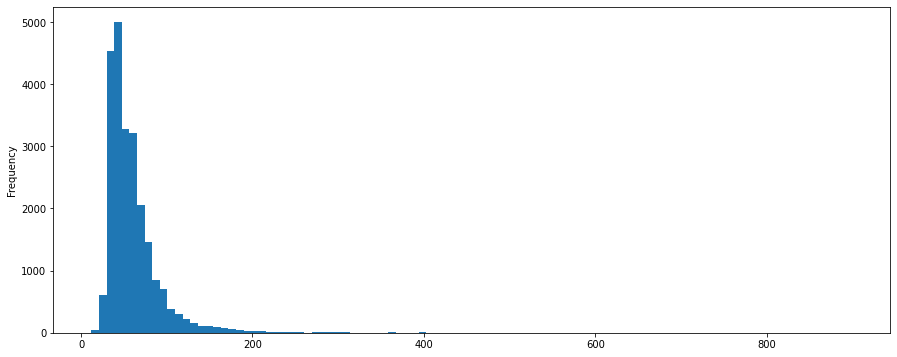

In [ ]:
df['total_area'].plot.hist(bins=100, figsize=(15, 6));

### Жилая площадь

Жилая площадь дома обычно 29 $м^2$. Минимальная 0 $м^2$, то есть отсутствует, а максимальная 409 $м^2$.

In [ ]:
df['living_area'].describe()

count    23555.000000
mean        31.731090
std         23.113304
min          0.000000
25%         17.800000
50%         29.000000
75%         41.100000
max        409.700000
Name: living_area, dtype: float64

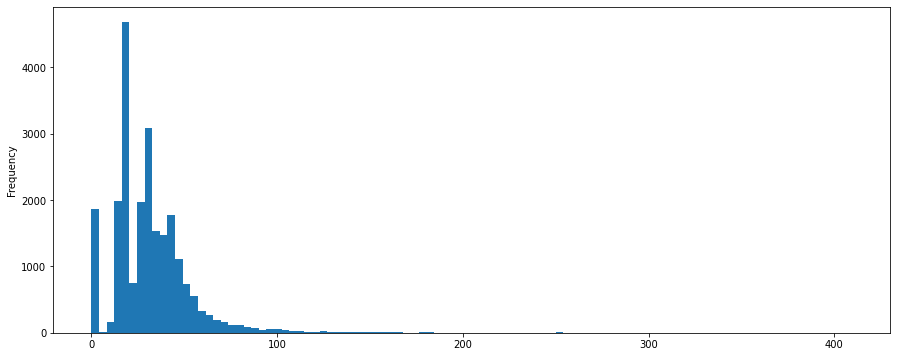

In [ ]:
df['living_area'].plot.hist(bins=100, figsize=(15, 6));

### Площадь кухни

Площадь кухни обычно 9 $м^2$. Минимальная 0 $м^2$, то есть отсутствует, а максимальная 112 $м^2$.

In [ ]:
df['kitchen_area'].describe()

count    23555.000000
mean         9.566379
std          6.408445
min          0.000000
25%          6.300000
50%          9.000000
75%         11.435000
max        112.000000
Name: kitchen_area, dtype: float64

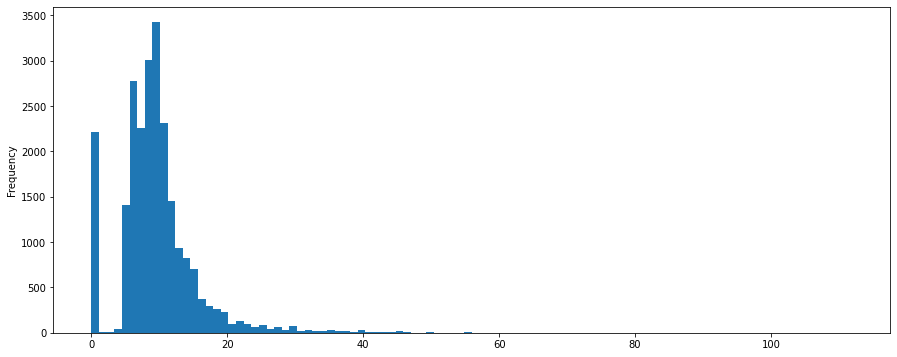

In [ ]:
df['kitchen_area'].plot.hist(bins=100, figsize=(15, 6));

### Цена объекта

In [ ]:
df['last_price'].describe()

count    2.355500e+04
mean     6.540996e+06
std      1.091297e+07
min      4.300000e+05
25%      3.400000e+06
50%      4.646000e+06
75%      6.794500e+06
max      7.630000e+08
Name: last_price, dtype: float64

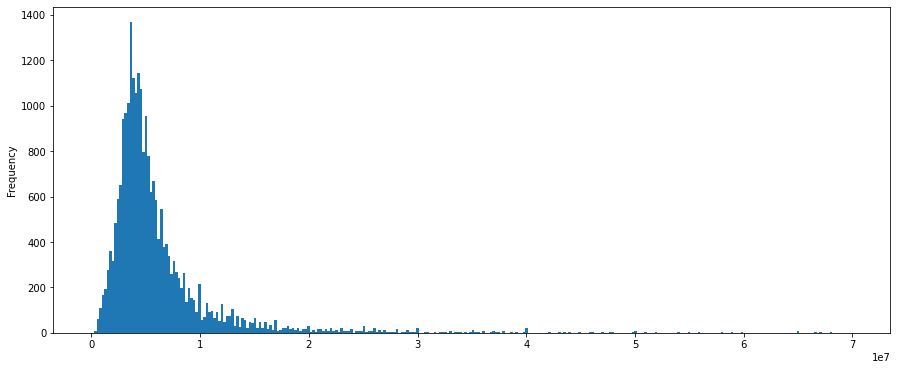

In [ ]:
df['last_price'].plot.hist(bins=300, figsize=(15, 6), range=(0, 70_000_000));

Основное количество объявлений с ценой меньше 6 800 000.

In [ ]:
df.query('last_price < 6_800_000').shape

(17670, 29)

Дальше шаг цен сильно разный и растёт вплоть до 763 000 000. За эту цену объект не самой большой площадю.

In [ ]:
df.query('last_price > 200_000_000').sort_values(by='last_price')

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment,locality_name_new,square_meter_price,week_day,month_exposition,year_exposition,floor_type,city_centers_nearest_km
5880,Санкт-Петербург,230000000,2017-05-31T00:00:00,50.0,6,500.0,0.0,40.0,2.726368,7,7,32440.0,5297.0,0,0,2,198,0,3,False,False,False,Санкт-Петербург,460000,2,5,2017,последний,5
13723,Санкт-Петербург,240000000,2017-04-01T00:00:00,199.0,6,410.0,218.0,40.0,3.400000,7,7,32440.0,5297.0,0,0,2,198,0,7,False,False,False,Санкт-Петербург,585365,5,4,2017,последний,5
16429,Санкт-Петербург,245000000,2017-04-10T00:00:00,249.0,6,285.7,182.8,29.8,3.350000,7,4,33143.0,6235.0,3,400,3,140,0,17,False,False,False,Санкт-Петербург,857542,0,4,2017,другой,6
22775,Санкт-Петербург,289238400,2019-03-19T00:00:00,95.0,2,187.5,63.7,30.2,3.370000,6,6,22494.0,1073.0,3,386,3,188,0,18,False,False,False,Санкт-Петербург,1542604,1,3,2019,последний,1
15622,Санкт-Петербург,300000000,2017-12-18T00:00:00,111.0,7,618.0,258.0,70.0,3.400000,7,5,32440.0,5297.0,0,0,2,198,0,20,False,False,False,Санкт-Петербург,485436,0,12,2017,другой,5
1435,Санкт-Петербург,330000000,2018-04-04T00:00:00,233.0,3,190.0,95.0,40.0,3.500000,7,5,23011.0,1197.0,3,519,3,285,0,19,False,False,False,Санкт-Петербург,1736842,2,4,2018,другой,1
14678,Санкт-Петербург,401300000,2016-02-20T00:00:00,393.0,5,401.0,204.0,24.0,2.726368,9,9,21912.0,2389.0,1,545,1,478,3,15,False,False,False,Санкт-Петербург,1000748,5,2,2016,последний,2
19498,Санкт-Петербург,420000000,2017-12-06T00:00:00,106.0,12,900.0,409.7,112.0,2.800000,25,25,30706.0,7877.0,0,0,2,318,0,8,False,False,False,Санкт-Петербург,466666,2,12,2017,последний,7
12947,Санкт-Петербург,763000000,2017-09-30T00:00:00,33.0,7,400.0,250.0,0.0,2.726368,10,10,25108.0,3956.0,1,530,3,756,2,19,False,False,False,Санкт-Петербург,1907500,5,9,2017,последний,3


### Количество комнат

В основном количество комнат 2. Минимум 1, а максимум 19 комнат.

In [ ]:
df['rooms'].describe()

count    23555.000000
mean         2.079091
std          1.066596
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

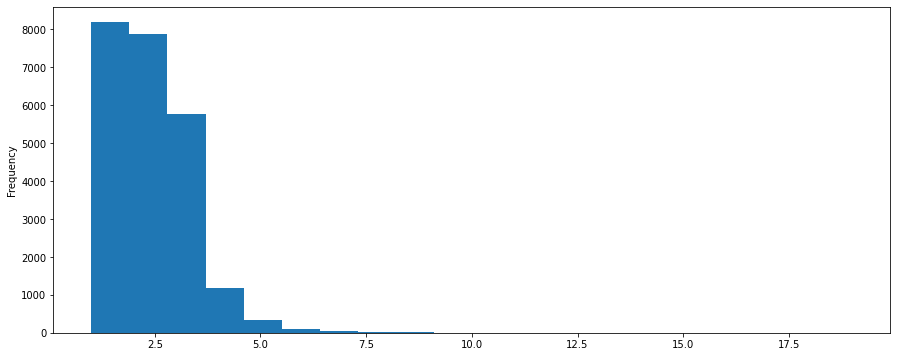

In [ ]:
df['rooms'].plot.hist(bins=20, figsize=(15, 6));

In [ ]:
df.query('rooms > 7')

,locality_name,last_price,first_day_exposition,days_exposition,rooms,total_area,living_area,kitchen_area,ceiling_height,floors_total,floor,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,balcony,total_images,open_plan,studio,is_apartment,locality_name_new,square_meter_price,week_day,month_exposition,year_exposition,floor_type,city_centers_nearest_km
648,Санкт-Петербург,17500000,2018-07-01T00:00:00,95.0,11,183.7,138.8,13.3,3.400000,7,7,23606.0,3148.0,0,0,0,0,0,3,False,False,False,Санкт-Петербург,95264,6,7,2018,последний,3
813,Санкт-Петербург,16500000,2016-02-25T00:00:00,806.0,8,229.0,160.0,25.0,2.726368,6,5,23968.0,4536.0,1,243,0,0,0,7,False,False,False,Санкт-Петербург,72052,3,2,2016,другой,4
866,Санкт-Петербург,25000000,2017-12-23T00:00:00,418.0,14,363.0,222.0,16.6,3.160000,5,4,38076.0,7950.0,0,0,2,435,0,5,False,False,False,Санкт-Петербург,68870,5,12,2017,другой,7
4143,Санкт-Петербург,23000000,2018-01-11T00:00:00,95.0,10,272.6,145.9,18.8,3.140000,7,7,10726.0,12169.0,1,191,1,531,1,6,False,False,False,Санкт-Петербург,84372,3,1,2018,последний,12
4427,Санкт-Петербург,22190000,2017-12-05T00:00:00,115.0,8,191.2,115.8,5.0,2.900000,6,1,21589.0,1152.0,1,587,2,155,0,13,False,False,False,Санкт-Петербург,116056,1,12,2017,первый,1
5348,Санкт-Петербург,65000000,2019-02-14T00:00:00,14.0,15,590.0,409.0,100.0,3.500000,6,3,24447.0,4666.0,1,767,0,0,0,20,False,False,False,Санкт-Петербург,110169,3,2,2019,другой,4
7840,Санкт-Петербург,150000000,2017-10-25T00:00:00,135.0,8,230.0,220.0,0.0,2.726368,8,8,25525.0,5845.0,2,116,0,0,0,11,False,False,False,Санкт-Петербург,652173,2,10,2017,последний,5
8740,Санкт-Петербург,16100000,2018-07-10T00:00:00,95.0,8,150.0,107.0,7.2,2.920000,5,1,26080.0,4782.0,2,473,0,0,0,5,False,False,False,Санкт-Петербург,107333,1,7,2018,первый,4
8804,Санкт-Петербург,49968900,2017-07-12T00:00:00,471.0,9,398.0,160.1,41.0,3.000000,2,1,17720.0,16722.0,3,471,2,440,0,14,False,False,False,Санкт-Петербург,125550,2,7,2017,первый,16
8842,Санкт-Петербург,17000000,2018-07-14T00:00:00,90.0,9,235.0,0.0,0.0,3.000000,6,3,24466.0,5034.0,1,346,0,0,0,12,False,False,False,Санкт-Петербург,72340,5,7,2018,другой,5


### Высота потолков

Средняя высота потолков 2.72 м. Минимальная 2, а максимальная 6 метров.

In [ ]:
df['ceiling_height'].describe()

count    23555.000000
mean         2.726348
std          0.218324
min          2.000000
25%          2.600000
50%          2.726368
75%          2.726368
max          6.000000
Name: ceiling_height, dtype: float64

### Этаж квартиры

Чаще всего продаёют квартиру 4-6 этажа. Берут на 1. И на максимально высоком 33 этаже.

In [ ]:
df['floor'].describe()

count    23555.000000
mean         5.878200
std          4.871515
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

### Тип этажа квартиры

По типу этажей чаще всего выбирают 'другой'.

In [ ]:
df['floor_type'].describe()

count      23555
unique         3
top       другой
freq       17319
Name: floor_type, dtype: object

### Общее количество этажей в доме

В основном объекты находятся в 9-11 этажных домах. Минимальное количество этажей в доме 1, максимальное 60.

In [ ]:
df['floors_total'].describe()

count    23555.000000
mean        10.674973
std          6.593124
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

### Расстояние до центра города в метрах

В общем случае центр города находится в 23 км от дома. Минимальное расстояние 181 метр, а максимальное 308 км

In [ ]:
df['city_centers_nearest'].describe()

count     23555.000000
mean      23512.322411
std       29906.291739
min         181.000000
25%       10935.000000
50%       14234.000000
75%       21502.000000
max      308019.032972
Name: city_centers_nearest, dtype: float64

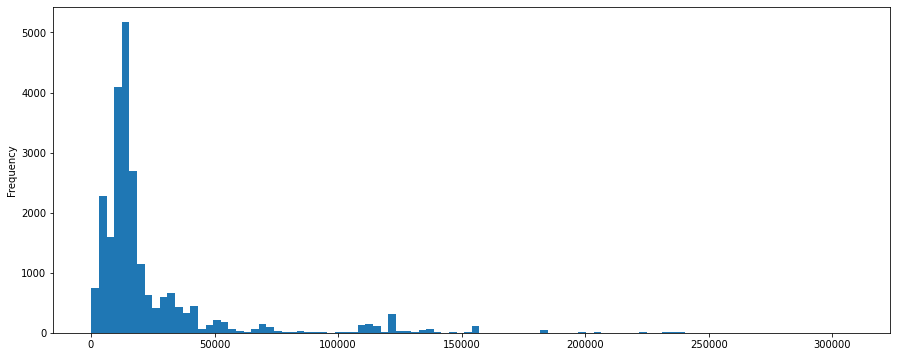

In [ ]:
df['city_centers_nearest'].plot.hist(bins=100, figsize=(15, 6));

### Расстояние до ближайшего аэропорта

Среднее 29 км. Минимальное 0. Максимальное 317056 км.

In [ ]:
df['airports_nearest'].describe()

count     23555.000000
mean      35339.738089
std       27904.037796
min           0.000000
25%       19945.500000
50%       29103.246543
75%       39847.000000
max      317056.254564
Name: airports_nearest, dtype: float64

### Расстояние до ближайшего парка

Обычное расстояние до парка 167 метров. Минимальное 0. Максимальное 3190.

In [ ]:
df['parks_nearest'].describe()

count    23555.000000
mean       167.169688
std        306.327145
min          0.000000
25%          0.000000
50%          0.000000
75%        301.000000
max       3190.000000
Name: parks_nearest, dtype: float64

### День и месяц публикации объявления

По дню недели видно что в выходные покупают примерно в 2 раза меньше чем в будни

In [ ]:
df.groupby('week_day')['week_day'].count()

week_day
0    3595
1    4161
2    3945
3    4276
4    3977
5    1918
6    1683
Name: week_day, dtype: int64

По месяцу публикации можно предположить что есть сезонность в 'Февраль', 'Март', 'Апрель', количество продаж очень велико, а так же после спада есть плавный подём с 'Июня' по 'Ноябрь'

In [ ]:
me = df.groupby('month_exposition')['month_exposition'].count()
me

month_exposition
1     1487
2     2636
3     2574
4     2356
5     1260
6     1746
7     1685
8     1737
9     1971
10    2106
11    2359
12    1638
Name: month_exposition, dtype: int64

<AxesSubplot:>

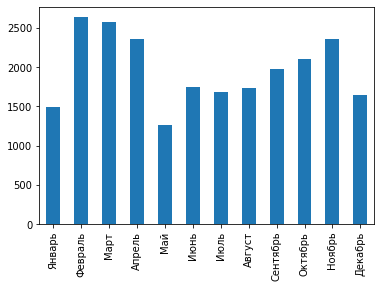

In [ ]:
me.index = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
me.plot.bar()

### Скорость продажи квартиры

In [ ]:
print(f'Среднее {df["days_exposition"].mean()}\nМедиана {df["days_exposition"].median()}')

Среднее 169.95340691997453
Медиана 95.0


In [ ]:
df['days_exposition'].describe()

count    23555.000000
mean       169.953407
std        206.974832
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

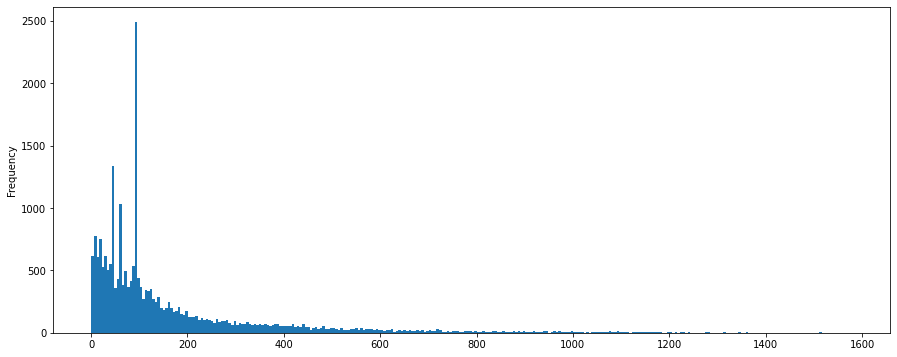

In [ ]:
df['days_exposition'].plot.hist(bins=300, figsize=(15, 6));

Быстрые продажи укладываются в 45 дней и меньше  
Долгими можно называть 199 дней и больше

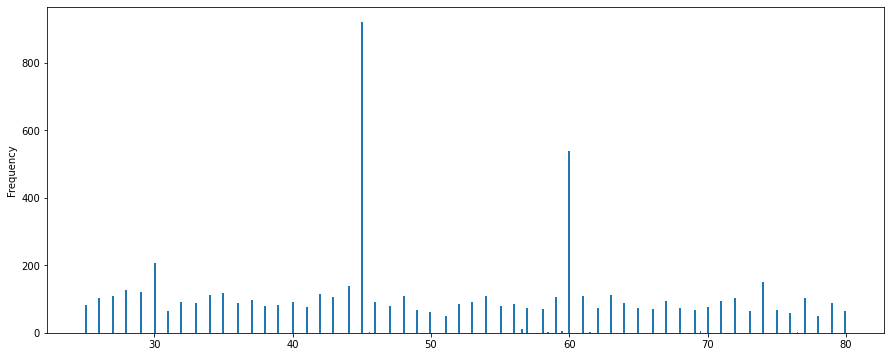

In [ ]:
df['days_exposition'].plot.hist(bins=400, range=(25,80),figsize=(15, 6));

## Выявление факторов влияющих на стоимость объекта

### Зависимость цены от общей площади

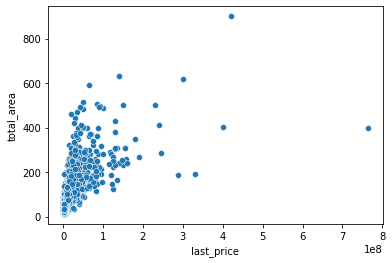

In [ ]:
sns.scatterplot(x=df['last_price'], y=df['total_area']);

In [ ]:
df[['last_price','total_area']].corr()

,last_price,total_area
last_price,1.000000,0.653728
total_area,0.653728,1.000000


Общая площадь сильно влияет на цену (по критерию Пирсона). С ростом площади, растёт цена.

### Зависимость цены от жилой площади

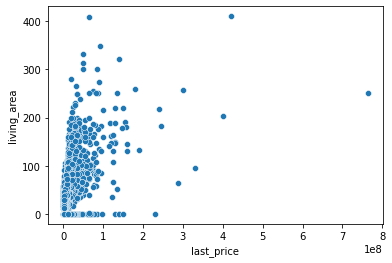

In [ ]:
sns.scatterplot(x=df['last_price'], y=df['living_area']);

In [ ]:
df[['last_price','living_area']].corr()

,last_price,living_area
last_price,1.00000,0.49131
living_area,0.49131,1.00000


Жилая площадь так же существенно влияет на цену, но меньше чем общая площадь.

### Зависимость цены от площади кухни

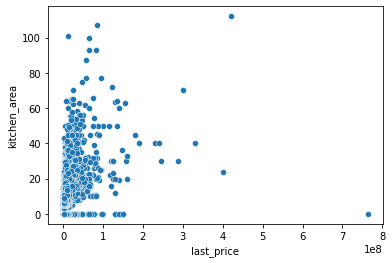

In [ ]:
sns.scatterplot(x=df['last_price'], y=df['kitchen_area']);

In [ ]:
df[['last_price','kitchen_area']].corr()

,last_price,kitchen_area
last_price,1.000000,0.387572
kitchen_area,0.387572,1.000000


Площадь кухни влияет на цену чуть меньше чем жилая площадь.

### Зависимость цены от количества комнат

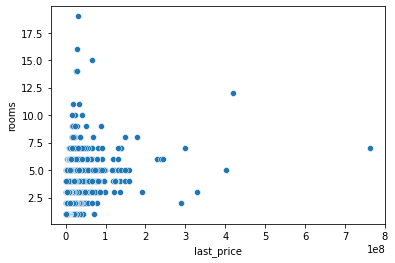

In [ ]:
sns.scatterplot(x=df['last_price'], y=df['rooms']);

In [ ]:
df[['last_price','rooms']].corr()

,last_price,rooms
last_price,1.000000,0.365094
rooms,0.365094,1.000000


Количество комнат незначительно влияет на цену. С ростом количества комнат цена увеличивается.

### Зависимость цены от типа этажа

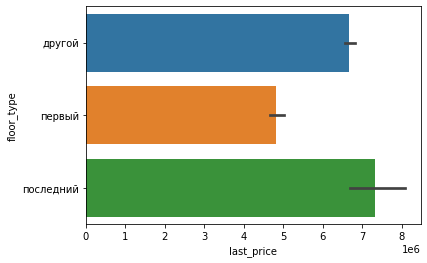

In [ ]:
sns.barplot(x=df['last_price'], y=df['floor_type']);

На первом этаже цена сильно ниже (3 000 000) чем на последнем или любом другом.

### Зависимость цены от дня недели публикации

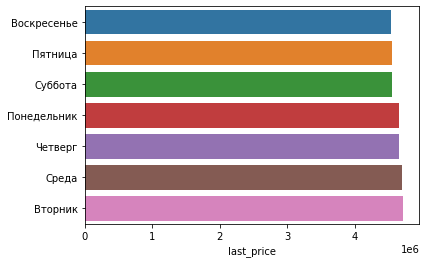

In [ ]:
r = df.pivot_table(index='week_day', values='last_price', aggfunc='median')
r.index = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
r = r.sort_values(by='last_price')
sns.barplot(x=r['last_price'], y=r.index);

В выходные и пятницу цена незначительно ниже, а в остальные чуть выше.

### Зависимость цены от месяца публикации

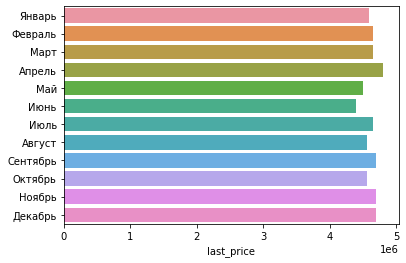

In [ ]:
d = df.pivot_table(index='month_exposition', values='last_price', aggfunc='median')
d.index = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
sns.barplot(x=d['last_price'], y=d.index, orient='h');

In [ ]:
d.describe()

,last_price
count,1.200000e+01
mean,4.623750e+06
std,1.051217e+05
min,4.400000e+06
25%,4.570000e+06
50%,4.650000e+06
75%,4.696250e+06
max,4.800000e+06


По самой большой медианной цене (4 800 000) объект можно продать разместив объявление в Апреле, затем идёт спад влоть до Июня включительно, самого меньшего по цене месяца (4 400 000). В остальные месяцы цена немного (100 000) колеблется.

### Зависимость цены от года публикации

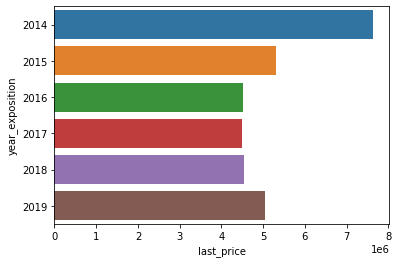

In [ ]:
ye = df.pivot_table(index='year_exposition', values='last_price', aggfunc='median')
sns.barplot(x=ye['last_price'], y=ye.index, orient='h');

In [ ]:
ye.describe()

,last_price
count,6.000000e+00
mean,5.259167e+06
std,1.212173e+06
min,4.500000e+06
25%,4.523750e+06
50%,4.800000e+06
75%,5.237500e+06
max,7.640000e+06


В 2014 было в среднем больше выручка, приблизительно на 2 700 000 больше за квартиру, то есть за 7 700 000

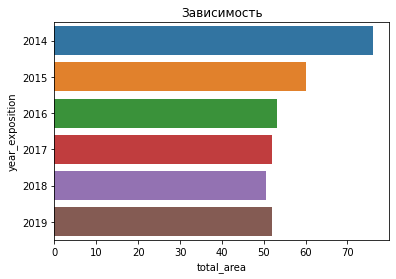

In [ ]:
ye_area = df.pivot_table(index='year_exposition', values='total_area', aggfunc='median')
sns.barplot(x=ye_area['total_area'], y=ye_area.index, orient='h').set_title('Зависимость');

В пересчёте на квадратный метр (нормировка)

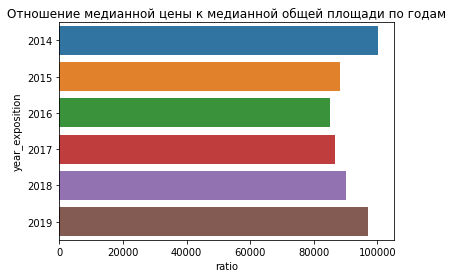

In [ ]:
ratio = pd.DataFrame({ 'ratio': ye['last_price'] / ye_area['total_area']})
sns.barplot(x=ratio['ratio'], y=ratio.index, orient='h').set_title('Отношение медианной цены к медианной общей площади по годам');

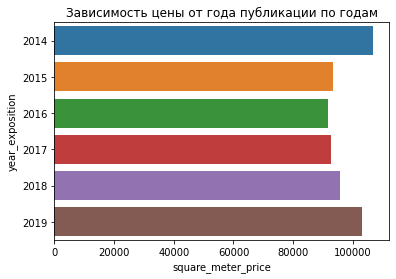

In [ ]:
ye_area2 = df.pivot_table(index='year_exposition', values='square_meter_price', aggfunc='median')
sns.barplot(x=ye_area2['square_meter_price'], y=ye_area2.index, orient='h').set_title('Зависимость цены от года публикации по годам');

In [ ]:
ye_area2.describe()

,square_meter_price
count,6.000000
mean,97219.333333
std,6317.719048
min,91666.000000
25%,92756.625000
50%,94492.500000
75%,101312.250000
max,106901.500000


В 2014 году самая высокая цена за квадратный метр 106901. Затем идёт спад до 2016 года до 91666. Затем снова рост до 2019 года до 103199.

### Средняя цена в 10 популярных для продажи населённых пунктах

Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`.

In [ ]:
top_ten = df.groupby('locality_name_new').count().sort_values(by='square_meter_price', ascending=False).head(10)['square_meter_price']

In [ ]:
ab = df.pivot_table(index='locality_name_new', values='square_meter_price', aggfunc=['count', 'mean']).reset_index()
ab.columns = ['locality_name_new', 'count', 'mean']
# Самые популярные (наибольшее число объявлений)
ab = ab.sort_values(by='count', ascending=False)[0:10]
# Отсортировать про средней цене квадратного метра
ab = ab.sort_values(by='mean', ascending=False)
ab

,locality_name_new,count,mean
223,Санкт-Петербург,15644,114810.965482
202,Пушкин,369,103125.373984
105,Кудрово,470,95260.393617
170,Парголово,327,90111.923547
146,Мурино,586,85940.518771
298,Шушары,439,78533.120729
88,Колпино,338,75404.733728
42,Гатчина,307,68666.609121
34,Всеволожск,398,68580.520101
35,Выборг,237,58141.489451


Самая низкая и высокая цена

In [ ]:
ab.loc[ab['mean'] == ab['mean'].min()]

,locality_name_new,count,mean
35,Выборг,237,58141.489451


In [ ]:
ab.loc[ab['mean'] == ab['mean'].max()]

,locality_name_new,count,mean
223,Санкт-Петербург,15644,114810.965482


### Средняя цена каждого километра от центра города

Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.

In [ ]:
mean_km_price = df.query('locality_name_new == "Санкт-Петербург"').groupby('city_centers_nearest_km').mean()['square_meter_price']
mean_km_price

city_centers_nearest_km
0     187323.674419
1     166539.208333
2     146662.420195
3     129471.795802
4     137412.971207
5     146947.018229
6     152277.455319
7     141376.373464
8     119770.830330
9     110140.818314
10    111449.342889
11    106619.622064
12    110060.963717
13    107120.467719
14    104933.057884
15    101806.740525
16    100004.636199
17     94665.973129
18     94814.537572
19     95433.951220
20    106900.469880
21     91399.589744
22     88714.237410
23     92720.233333
24     82439.909091
25     90436.553846
26     75171.333333
27    132115.000000
28     81840.200000
29     62481.666667
Name: square_meter_price, dtype: float64

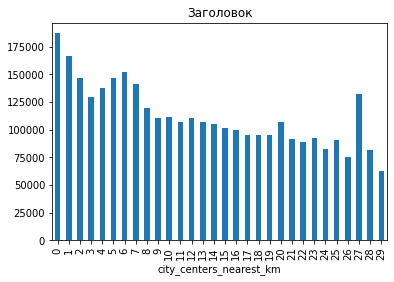

In [ ]:
mean_km_price.plot.bar(title = 'Заголовок');

In [ ]:
mean_km_price.reset_index().corr()

,city_centers_nearest_km,square_meter_price
city_centers_nearest_km,1.000000,-0.841846
square_meter_price,-0.841846,1.000000


В целом чем ближе к центру тем выше цена, хотя есть и значительный "всплеск" в районе 6 километров. Зависимость очень сильная.

## Общий вывод

Были получены данные о продаже квартир за 2014-2019 год в Ленинградской области (Санкт-Петербург и соседние населённые пункты).  

В исследовании нужно было установить параметры по которым можно определить рыночную стоимость недвижимости для обнаружения аномалий и мошеннической деятельности.

- В предоставленных данных обнаружились проблемы которые были исправлены в предобработке. По их исправлению для выгрузки даны [рекомендации](#%D0%A0%D0%B5%D0%BA%D0%BE%D0%BC%D0%B5%D0%BD%D0%B4%D0%B0%D1%86%D0%B8%D0%B8-%D0%BA%D0%BE%D0%BC%D0%B0%D0%BD%D0%B4%D0%B5-%D0%BF%D1%80%D0%B5%D0%B4%D0%BE%D1%81%D1%82%D0%B0%D0%B2%D0%BB%D1%8F%D1%8E%D1%89%D0%B5%D0%B9-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5).
- Написан алгоритм поиска географических координат для восполнения недостающих расстояний от центра города и аэропорта.
- По существующим данным были рассчитаны вспомогательные столбцы.
- Найдены типичные показатели по данным:

| Параметр | Минимум | Типичный показатель | Максимум |
|---|:-:|:-:|:-:|
| Общая площадь | 12 $м^2$ | 52 $м^2$ | 900 $м^2$ |
| Жилая площадь | 0 $м^2$ | 29 $м^2$ | 409 $м^2$ |
| Площадь кухни | 0 $м^2$ | 9 $м^2$ | 112 $м^2$ |
| Цена продажи | 4 300 000 | 4 646 000 | 763 000 000 |
| Количество комнат | 1 | 2 | 19 |
| Высота потолков | 2 м | 2.72 м | 6 м |
| Этаж | 1 | 4-6 | 33 |
| Этажей в доме | 1 | 9-11 | 60 |
| Расстояние до центра города | 181 м | 23 км | 308 км |
| Расстояние до аэропорта | 0 | 29 км | 317 км |
| Расстояние до парка | 0 | 167 м | 3190 м |

    Большинство цен меньше 6 800 000.

    Среди типов этажей 'первый', 'последний' и 'другой' чаще всего выбирают 'другой'.

    По дню недели видно что в выходные покупают примерно в 2 раза меньше чем в будни.

    По месяцу публикации можно предположить что есть сезонность в 'Февраль', 'Март', 'Апрель', количество продаж очень велико, а так же после спада есть плавный подём с 'Июня' по 'Ноябрь'

    Скорость продажи: Среднее 169, Медиана 95  
    Быстрые продажи укладываются в 45 дней и меньше  
    Долгими можно называть 199 дней и больше

- По критерию Пирсона было оценено влияние параметров на стоимость квартиры:

| Коэффициент | Параметр |
|:-:|---|
| -0.84 | Дальность от центра города в км |
| 0.65 | Общая площадь |
| 0.49 | Жилая площадь |
| 0.38 | Площадь кухни |
| 0.36 | Количество комнат |

- Сделаны выводы:
    - На первом этаже цена сильно ниже (на 3 000 000) чем на последнем или любом другом.
    - В выходные и пятницу цена незначительно ниже, а в остальные незначительно выше.
    - По самой большой медианной цене (4 800 000) объект можно продать разместив объявление в Апреле, затем идёт спад влоть до Июня включительно, самого меньшего по цене месяца (4 400 000). В остальные месяцы цена немного (100 000) колеблется.
    - В 2014 году самая высокая цена за квадратный метр 106901. Затем идёт спад до 2016 года до 91666. Затем снова рост до 2019 года до 103199.
    - Чем ближе квартира к центру тем выше цена, хотя есть и значительный "всплеск" в районе 6 километров. Зависимость очень и самая сильная в предоставленных данных.
- Был составлен [топ 10 популярных для продажи населённых пунктах со средней ценой за квадратный метр](#%D0%A1%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F-%D1%86%D0%B5%D0%BD%D0%B0-%D0%B2-10-%D0%BF%D0%BE%D0%BF%D1%83%D0%BB%D1%8F%D1%80%D0%BD%D1%8B%D1%85-%D0%B4%D0%BB%D1%8F-%D0%BF%D1%80%D0%BE%D0%B4%D0%B0%D0%B6%D0%B8-%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D1%91%D0%BD%D0%BD%D1%8B%D1%85-%D0%BF%D1%83%D0%BD%D0%BA%D1%82%D0%B0%D1%85)

- Самой высокой цены можно было добиться выставив объявление о продаже квартиры в Санкт-Петербурге на любом этаже кроме первого, в Апреле, во Вторник, как можно ближе к центру города и как можно большей общей площадью. Так же в 2014 году были самые высокие цены.

Таким образом бизнес может отслеживать аномальные значения выбивающиеся из представленных в исследовании. Например будет подозрительно если близко к центру города, будет выставлена низкая цена, или наоборот вдали от города высокая. Или если общая площадь и цена сильно не соответствуют друг другу.